In [1]:
pwd

'/scratch/yl7692'

# 2.Preprocess the Datasets

In [2]:
pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import glob
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets.widgets import * 
import ipywidgets as widgets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from tqdm import tqdm

## 1) Visualize the MRI images 

In [45]:
datapath_root = '/scratch/yl7692/training'
SAVE_PATH = '/scratch/yl7692/self-attention_Unet_AND/'

<ipython-input-15-fe635c2ddc74>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  T1_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_mprage_pp.nii').get_data()
<ipython-input-15-fe635c2ddc74>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  T2_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_t2_pp.nii').get_data()
<ipython-input-15-fe635c2ddc74>:3: DeprecationWarning: get_data() is deprecated in f

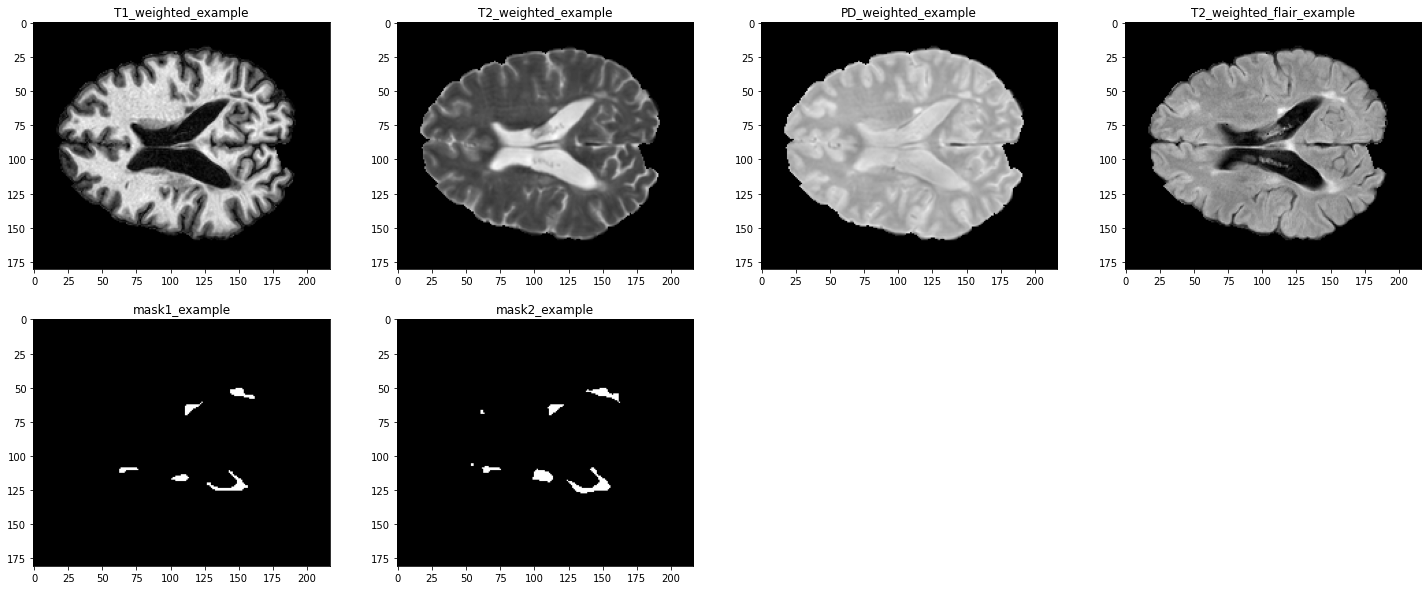

In [15]:
T1_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_mprage_pp.nii').get_data()
T2_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_t2_pp.nii').get_data()
PD_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_pd_pp.nii').get_data()
T2_weighted_flair_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_flair_pp.nii').get_data()
mask1_example = nib.load(datapath_root + '/training01/masks/training01_01_mask1.nii').get_data()
mask2_example = nib.load(datapath_root + '/training01/masks/training01_01_mask2.nii').get_data()
plt.figure(figsize=(25,10))
plt.subplot(2,4,1)
plt.imshow(T1_weighted_example[:,:,90],'gray')
plt.title('T1_weighted_example')
plt.subplot(2,4,2)
plt.imshow(T2_weighted_example[:,:,90],'gray')
plt.title('T2_weighted_example')
plt.subplot(2,4,3)
plt.imshow(PD_weighted_example[:,:,90],'gray')
plt.title('PD_weighted_example')
plt.subplot(2,4,4)
plt.imshow(T2_weighted_flair_example[:,:,90],'gray')
plt.title('T2_weighted_flair_example')
plt.subplot(2,4,5)
plt.imshow(mask1_example[:,:,90],'gray')
plt.title('mask1_example')
plt.subplot(2,4,6)
plt.imshow(mask2_example[:,:,90],'gray')
plt.title('mask2_example')

plt.pause(3)

In [6]:
# ipywidgets for some interactive plots

# slide through dicom images using a slide bar 
def dicom_animation(x):
    plt.figure(figsize=(20,10))
    plt.imshow(T1_weighted_example[:,:,x],'gray')
    return x
interact(dicom_animation, x=(0, len(T1_weighted_example)-1))

interactive(children=(IntSlider(value=90, description='x', max=180), Output()), _dom_classes=('widget-interact…

<function __main__.dicom_animation(x)>

## 2) Define function to process 2 raters' groundtruth  

In [10]:
def weight_ground_truth(mask1_path, mask2_path):
    mask1=nib.load(mask1_path).get_data()
    mask2=nib.load(mask2_path).get_data()
    if mask1.shape==mask2.shape:
        fig_shape = mask1.shape 
    else:
        print('Number inconformity for mask, double check path!')
  
    n=fig_shape[2]

    mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
    mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
    mask_rnd_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)

    for i in range(n):
        mask_and_weight[:,:,i] = mask1[:,:,i] & mask2[:,:,i]
        mask_or_weight[:,:,i] = mask1[:,:,i] | mask2[:,:,i]
        mask_rnd_weight = (mask_or_weight - mask_and_weight)*np.random.randint(0,2,(fig_shape[0],fig_shape[1],n)) + mask_and_weight


    return mask_and_weight, mask_or_weight, mask_rnd_weight


<ipython-input-7-f3023dfad3f4>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask1=nib.load(mask1_path).get_data()
<ipython-input-7-f3023dfad3f4>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask2=nib.load(mask2_path).get_data()


Text(0.5, 1.0, 'mask_rnd_weight')

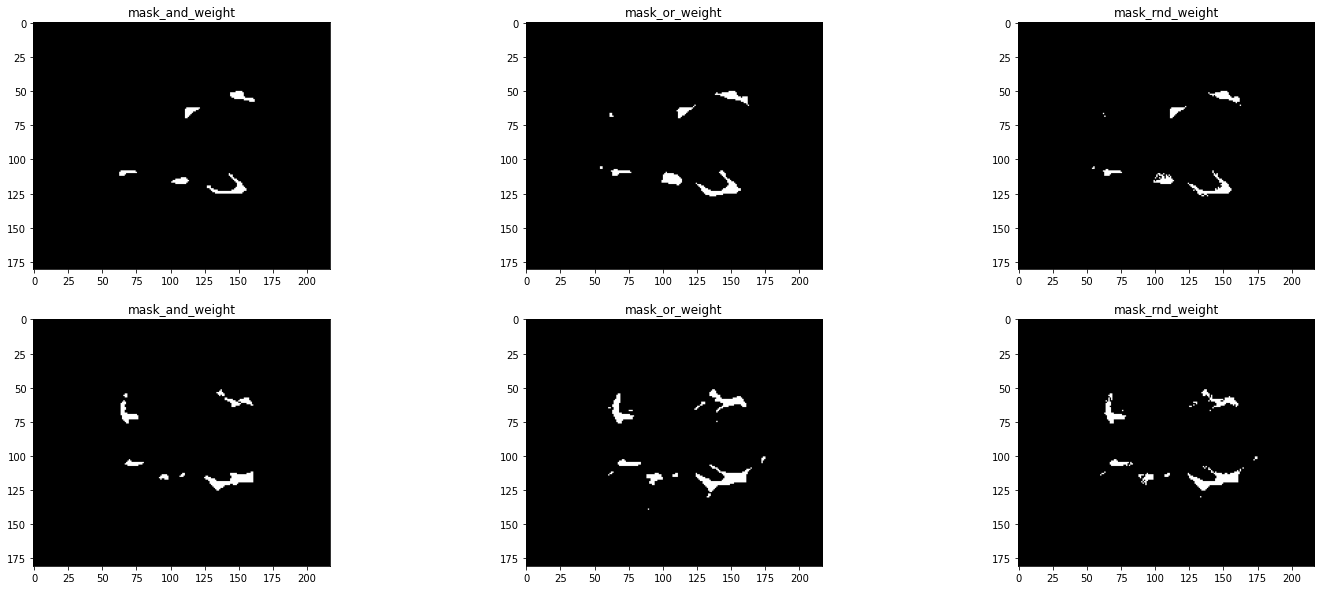

In [8]:
#mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
#mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
mask1_path = os.path.join(datapath_root,'training01/masks/training01_01_mask1.nii')
mask2_path = os.path.join(datapath_root,'training01/masks/training01_01_mask2.nii')
mask3_path = os.path.join(datapath_root,'training02/masks/training02_02_mask1.nii')
mask4_path = os.path.join(datapath_root,'training02/masks/training02_02_mask2.nii')

mask_and_weight, mask_or_weight, mask_rnd_weight = weight_ground_truth(mask1_path, mask2_path)
mask_and_weight2, mask_or_weight2, mask_rnd_weight2 = weight_ground_truth(mask3_path, mask4_path)

plt.figure(figsize=(25,10))
plt.subplot(2,3,1)
plt.imshow(mask_and_weight[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(2,3,2)
plt.imshow(mask_or_weight[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(2,3,3)
plt.imshow(mask_rnd_weight[:,:,90],'gray')
plt.title('mask_rnd_weight')
plt.subplot(2,3,4)
plt.imshow(mask_and_weight2[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(2,3,5)
plt.imshow(mask_or_weight2[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(2,3,6)
plt.imshow(mask_rnd_weight2[:,:,90],'gray')
plt.title('mask_rnd_weight')

<ipython-input-7-f3023dfad3f4>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask1=nib.load(mask1_path).get_data()
<ipython-input-7-f3023dfad3f4>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask2=nib.load(mask2_path).get_data()


Text(0.5, 1.0, 'mask_rnd_weight')

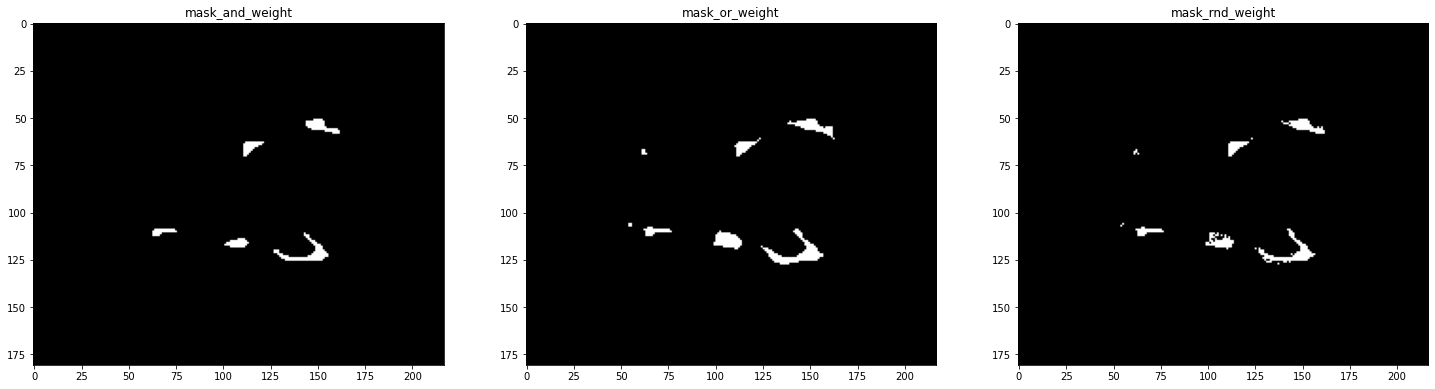

In [9]:
#root = '/content/gdrive/MyDrive/ImageVedioPrecessingProject/training/'
#mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
#mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
mask_and_weight, mask_or_weight, mask_rnd_weight = weight_ground_truth(mask1_path, mask2_path)
plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(mask_and_weight[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(1,3,2)
plt.imshow(mask_or_weight[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(1,3,3)
plt.imshow(mask_rnd_weight[:,:,90],'gray')
plt.title('mask_rnd_weight')

## 3) Make the custom dataset

In [6]:
second_path_list = ['training01/','training02/','training03/','training04/','training05/']
mri_list = []
mask1_list = []
mask2_list = []
for i in range(5):
    timepoint1_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_01_*.nii')
    timepoint2_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_02_*.nii')
    timepoint3_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_03_*.nii')
    timepoint4_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_04_*.nii')
    if i==2:
        timepoint5_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_05_*.nii')
    mask1_path = os.path.join(datapath_root, second_path_list[i], 'masks/*1.nii')
    mask2_path = os.path.join(datapath_root, second_path_list[i], 'masks/*2.nii')
    timepoint1_list = sorted(glob.glob(timepoint1_path))
    timepoint2_list = sorted(glob.glob(timepoint2_path))
    timepoint3_list = sorted(glob.glob(timepoint3_path))
    timepoint4_list = sorted(glob.glob(timepoint4_path))
    if i==2:
        timepoint5_list = sorted(glob.glob(timepoint5_path))
    mri_list.append(timepoint1_list)
    mri_list.append(timepoint2_list)
    mri_list.append(timepoint3_list)
    mri_list.append(timepoint4_list)
    if i==2:
        mri_list.append(timepoint5_list)
    mask1_list = mask1_list + sorted(glob.glob(mask1_path))
    mask2_list = mask2_list + sorted(glob.glob(mask2_path))
print('Data Collected:', len(mri_list))
print('Mask1 Collected:', len(mask1_list))
print('Mask2 Collected:', len(mask2_list))
print(mri_list[0])

Data Collected: 21
Mask1 Collected: 21
Mask2 Collected: 21
['/scratch/yl7692/training/training01/preprocessed/training01_01_flair_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_mprage_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_pd_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_t2_pp.nii']


<ipython-input-12-bbfdd6332bd2>:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ex = nib.load(mri_list[0][index+i]).get_data()
<ipython-input-12-bbfdd6332bd2>:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ms1 = nib.load(mask1_list[0]).get_data()
<ipython-input-12-bbfdd6332bd2>:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.

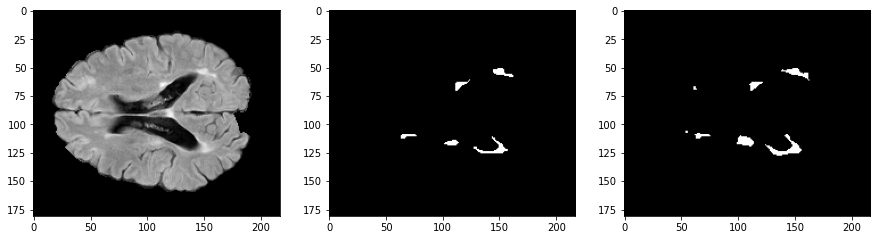

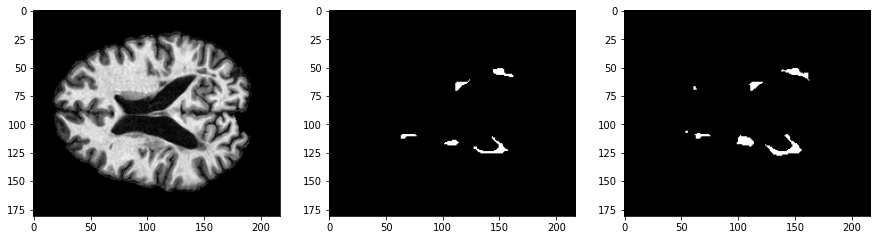

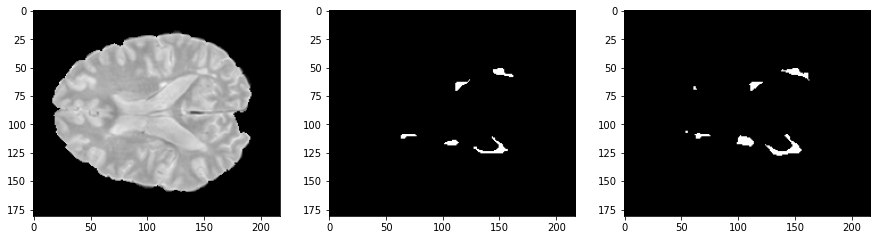

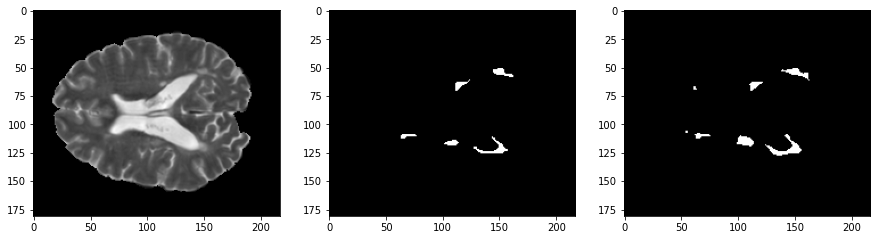

In [12]:
# 0-3:training 1(4 time points)
# 4-7:training 2(4 time points)
# 8-12:training 3(5 time points)
# 13-16:training 4(4 time points)
# 17-20:training 5(4 time points)
# order in one training set: t2_flair_weight, t1_weight, pd_weight, t2_weight

#Display one timepoint(4 type MRI) for one of the training set
index = 0
for i in range(4):
    ex = nib.load(mri_list[0][index+i]).get_data()
    ms1 = nib.load(mask1_list[0]).get_data()
    ms2 = nib.load(mask2_list[0]).get_data()
    plt.figure(figsize=(15,25))
    plt.subplot(5,3,3*i+1)
    plt.imshow(ex[:,:,90],'gray')
    plt.subplot(5,3,3*i+2)
    plt.imshow(ms1[:,:,90],'gray')
    plt.subplot(5,3,3*i+3)
    plt.imshow(ms2[:,:,90],'gray')

In [7]:
from random import shuffle
def shuffle_two_lists(listA, listB, listC):
    temp = list(zip(listA, listB, listC))
    shuffle(temp)
    return zip(*temp)
train_split_ratio = 0.8
test_split_ratio = 0.1
num_samples = len(mri_list)

train_size = int(num_samples * train_split_ratio)
test_size = int(num_samples * test_split_ratio)
val_size = num_samples - train_size - test_size
mri_list_shuffled, mask1_list_shuffled, mask2_list_shuffled = shuffle_two_lists(mri_list, mask1_list, mask2_list)

train_img_list, train_label1_list, train_label2_list = mri_list_shuffled[:train_size], mask1_list_shuffled[:train_size], mask2_list_shuffled[:train_size]
val_img_list, val_label1_list, val_label2_list = mri_list_shuffled[train_size:train_size+ val_size], mask1_list_shuffled[train_size:train_size + val_size], mask2_list_shuffled[train_size:train_size + val_size]
test_img_list, test_label1_list, test_label2_list = mri_list_shuffled[train_size+ val_size:], mask1_list_shuffled[train_size+ val_size:], mask2_list_shuffled[train_size+ val_size:]

print ("Training set size: {}". format(len(train_img_list)))
print ("Validation set size: {}". format(len(val_img_list)))
print ("Test set size: {}". format(len(test_img_list)))

Training set size: 16
Validation set size: 3
Test set size: 2


In [8]:
class MRIDataset(Dataset):
    def __init__(self, img_path_list, label1_path_list, label2_path_list, RULE = 'and', IF_TRAIN= False):
        self.mri_path_list = img_path_list
        self.label1_path_list = label1_path_list
        self.label2_path_list = label2_path_list
        self.rule = RULE
        self.IF_TRAIN = IF_TRAIN
        #self.transform=transforms.Compose([transforms.Normalize((0.5,),(0.5,))])
        self.mri_list, self.mask1_list, self.mask2_list, self.mask_and_list, self.mask_or_list, self.mask_rnd_list = self.preprocess() 

    def __len__(self):
        return len(self.mri_list)

    def preprocess(self):
        mri_list, mask1_list, mask2_list, mask_and_list, mask_or_list, mask_rnd_list = [], [], [], [], [], []
        for idx in tqdm(range(len(self.mri_path_list))):
            mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
            mri_t2f = (mri_t2f-mri_t2f.min())/(mri_t2f.max()-mri_t2f.min())
            
            mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
            mri_t1w = (mri_t1w-mri_t1w.min())/(mri_t1w.max()-mri_t1w.min())
            
            mri_pd = torch.Tensor(nib.load(self.mri_path_list[idx][2]).get_data())
            mri_pd = (mri_pd-mri_pd.min())/(mri_pd.max()-mri_pd.min())
            
            mri_t2w = torch.Tensor(nib.load(self.mri_path_list[idx][3]).get_data())
            mri_t2w = (mri_t2w-mri_t2w.min())/(mri_t2w.max()-mri_t2w.min())
            
            mri = torch.cat((mri_t1w.unsqueeze(0),mri_t2w.unsqueeze(0),mri_pd.unsqueeze(0),mri_t2f.unsqueeze(0)),axis=0)
            #mri = self.transform(mri)
            mask_and, mask_or, mask_rnd = weight_ground_truth(self.label1_path_list[idx], self.label2_path_list[idx])
            mask1 = torch.Tensor(nib.load(self.label1_path_list[idx]).get_data())
            mask2 = torch.Tensor(nib.load(self.label2_path_list[idx]).get_data())
            
            mri_list.append(mri)
            mask1_list.append(mask1)
            mask2_list.append(mask2)
            mask_and_list.append(mask_and)
            mask_or_list.append(mask_or)
            mask_rnd_list.append(mask_rnd)
        return mri_list, mask1_list, mask2_list, mask_and_list, mask_or_list, mask_rnd_list

    def __getitem__ (self,idx):
        img = self.mri_list[idx]
        if self.rule=='and':
            mask = self.mask_and_list[idx]
        elif self.rule=='or':
            mask = self.mask_or_list[idx]
        elif self.rule=='random':
            mask = self.mask_rnd_list[idx]
        elif self.rule=='mask1':
            mask = self.mask1_list[idx]
        elif self.rule=='mask2':
            mask = self.mask2_list[idx]
            
        label = torch.Tensor(mask)

        return img, label

In [11]:
dataset = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'and', IF_TRAIN= True)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-8-cc23401311c6>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-8-cc23401311c6>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-8-cc23401311c6>:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predi

torch.Size([4, 181, 217, 181])
torch.Size([181, 217, 181])
1.0
1.0
1.0
1.0


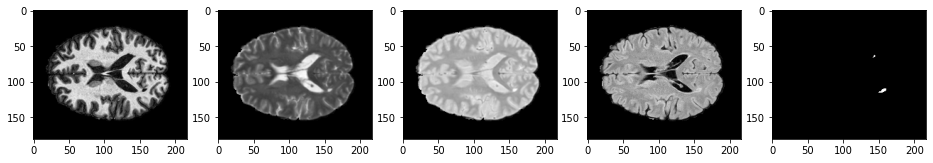

In [16]:
img, mask = dataset[0]
print(img.shape)
print(mask.shape)
plt.figure(figsize = (16,32))
plt.subplot(1,5,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,5)
plt.imshow(mask.cpu().numpy()[:,:,90],'gray')
print(img[0,:,:,:].cpu().numpy().max())
print(img[1,:,:,:].cpu().numpy().max())
print(img[2,:,:,:].cpu().numpy().max())
print(img[3,:,:,:].cpu().numpy().max())

In [12]:
train_dataset = MRIDataset(train_img_list, train_label1_list, train_label2_list, RULE = 'and', IF_TRAIN= True)
val_dataset = MRIDataset(val_img_list, val_label1_list, val_label2_list, RULE = 'and', IF_TRAIN= False)
test_dataset = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'and', IF_TRAIN= False)

  0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-8-cc23401311c6>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-8-cc23401311c6>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-8-cc23401311c6>:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more pred

In [13]:
NUM_EPOCH = 500
BATCH_SIZE = 8
LR = 0.0001

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

# 3.Build the Network

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class SelfAttention_3D(nn.Module):
    def __init__(self, feature_dims, dim_q):
        super(SelfAttention_3D, self).__init__()
        self.fc_q1 = nn.Linear(feature_dims, dim_q)
        self.fc_k1 = nn.Linear(feature_dims, dim_q)
        self.fc_v1 = nn.Linear(feature_dims, dim_q)
        
        self.fc_q2 = nn.Linear(feature_dims, dim_q)
        self.fc_k2 = nn.Linear(feature_dims, dim_q)
        self.fc_v2 = nn.Linear(feature_dims, dim_q)
        
        self.fc_q3 = nn.Linear(feature_dims, dim_q)
        self.fc_k3 = nn.Linear(feature_dims, dim_q)
        self.fc_v3 = nn.Linear(feature_dims, dim_q)
        
        self.fc_o = nn.Linear(3*dim_q, feature_dims)

    def forward(self, input_data):
        # Expect input_data to be of shape (batch_size, channels, l, w, h).
        batch_size, channels, l, w, h  = input_data.size()
        # (batch_size, n_pixels, channels)
        input_data = input_data.flatten().reshape(batch_size, channels, -1)

        # Linear transforms(head_1).
        queries1 = self.fc_q1(input=input_data)  # (batch_size, feature_dims, dim_q)
        keys1 = self.fc_k1(input=input_data)  # (batch_size, feature_dims, dim_q)
        values1 = self.fc_v1(input=input_data)  # (batch_size, feature_dims, dim_q)
        
        # Attention matrix1.
        dot1 = torch.bmm(queries1, keys1.transpose(1, 2))  # (batch_size, channels, channels)
        scaled_dot1 = torch.div(dot1, torch.sqrt(torch.tensor(l*w*h).float())) # scale
        atten_matrix1 = F.softmax(scaled_dot1, dim=1)
        atten_weighted1 = torch.bmm(atten_matrix1, values1)
        
        # Linear transforms(head_2).
        queries2 = self.fc_q2(input=input_data)  # (batch_size, feature_dims, dim_q)
        keys2 = self.fc_k2(input=input_data)  # (batch_size, feature_dims, dim_q)
        values2 = self.fc_v2(input=input_data)  # (batch_size, feature_dims, dim_q)
        
        # Attention matrix2.
        dot2 = torch.bmm(queries2, keys2.transpose(1, 2))  # (batch_size, channels, channels)
        scaled_dot2 = torch.div(dot2, torch.sqrt(torch.tensor(l*w*h).float())) # scale
        atten_matrix2 = F.softmax(scaled_dot2, dim=1)
        atten_weighted2 = torch.bmm(atten_matrix2, values2)
        
        # Linear transforms(head_3).
        queries3 = self.fc_q3(input=input_data)  # (batch_size, feature_dims, dim_q)
        keys3 = self.fc_k3(input=input_data)  # (batch_size, feature_dims, dim_q)
        values3 = self.fc_v3(input=input_data)  # (batch_size, feature_dims, dim_q)
        
        # Attention matrix3.
        dot3 = torch.bmm(queries3, keys3.transpose(1, 2))  # (batch_size, channels, channels)
        scaled_dot3 = torch.div(dot3, torch.sqrt(torch.tensor(l*w*h).float())) # scale
        atten_matrix3 = F.softmax(scaled_dot3, dim=1)
        atten_weighted3 = torch.bmm(atten_matrix3, values3)
        
        catlayer = torch.cat((atten_weighted1,atten_weighted2,atten_weighted3),dim=2)
        output = self.fc_o(catlayer).flatten().reshape(batch_size, channels, l, w, h)
        
        return output

In [17]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x
    
class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
    
    
class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

    
class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=4, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 4
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        #filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        self.Maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        
        self.attention1 = SelfAttention_3D(feature_dims=22*27*22, dim_q=10)
        self.attention2 = SelfAttention_3D(feature_dims=45*54*45, dim_q=10)
        #self.attention3 = SelfAttention_3D(feature_dims=91*109*91, dim_q=10)
        #self.attention4 = SelfAttention_3D(feature_dims=181*217*181, dim_q=10)
        
        self.Up5 = up_conv(filters[4], filters[3])
        #self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        #self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        #self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        #self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv3d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)
        #print("e1", e1.shape)
        e2 = self.Maxpool1((e1))
        e2 = self.Conv2(e2)
        #print("e2", e2.shape)
        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)
        #print("e3", e3.shape)
        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)
        #print("e4", e4.shape)
        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)
        #print("e5", e5.shape)
        #print("############")
        d5 = self.Up5(e5)
        #print(d5.shape)
        #e4 = e4[:,:,:,0:-1,:]
        #print("e4 new", e4.shape)
        
        #x4 = self.Att5(g=d5, x=e4)
        x4 = self.attention1(e4)
        #print("x4 new", x4.shape)
       
        #print("d5 new", d5.shape)
        d5 = torch.cat((x4[:,:,:,0:-1,:], d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        #e3 = e3[:,:,0:-1,0:-2,0:-1]
        #print("e3 new", e3.shape)
        #x3 = self.Att4(g=d4, x=e3)
        
        x3 = self.attention2(e3)
        #print("x3 new", x3.shape)
        d4 = torch.cat((x3[:,:,0:-1,0:-2,0:-1], d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        e2 = e2[:,:,0:-2,0:-4,0:-2]
        #print("e2 new", e2.shape)
        #x2 = self.Att3(g=d3, x=e2)
        #x2 = self.attention3(e2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        #print("d2", d2.shape)
        padding = nn.ConstantPad3d(((2, 3, 4, 5, 2, 3)), 0)
        d2 = padding(d2)
        #print("d2 new", d2.shape)
        #print("e1", e1.shape)
        #x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)


      #  out = self.active(out)

        return out

# 4.Dice Loss

In [18]:
# define dice coefficient
def dice_coeff(pred, target):
    smooth = 1
    # First let's flatten the matrix to [Batch Size, -1]
    # The flatten operation does not afftect the computation of the above equation
    num = pred.size(0)
    m1 = pred. view(num, -1). float() # Flatten
    m2 = target. view(num, -1). float() # Flatten
    # Then we compute the intersection and the sum of cardinality
    intersection = 2*torch.sum(m1*m2,dim= 1) + smooth
    cardinality = torch.sum(m1**2,dim= 1) + torch.sum(m2**2,dim= 1) + smooth
    # Followed by Dice
    dice = intersection/cardinality
    return dice.mean()
# define SoftDICE loss as 1 - SoftDICE
class SoftDICELoss(nn. Module):
    def __init__(self, smooth = 1):
        super(SoftDICELoss, self). __init__()
        self. smooth = smooth
    def forward(self, pred, target):
        loss = 1 - dice_coeff(pred, target)
        return loss.mean()

# 5.Training

In [19]:
def train_epoch(net, data_loader, optimizer, criterion, epoch):

    net = net.train()
    optimizer.zero_grad()
    loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask

        img = img.to(device)
        mask = mask.to(device)

        pred = net(img)

        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_stat += [loss.item()]*img.shape[0]
        print ("Epoch {}: [{}/{}] Loss: {:.3f}". format(epoch, len(data_loader), len(data_loader),np. mean(loss_stat)))
    return np.mean(loss_stat)

In [20]:
def eval_epoch(net, data_loader, metric, criterion):
    # set model in eval mode to avoid updating BN layer
    net = net.eval()
    
    metric_stat = []
    val_loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask
        # send data to device
        img = img.to(device)
        mask = mask.to(device)
        # feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss = criterion(pred, mask)
            
        # eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred>0.2
        err = dice_coeff(pred, mask)
        metric_stat += [err.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Val Loss: {:.3f} ".format(np.mean(metric_stat), np.mean(val_loss_stat)))
    
    return np.mean(val_loss_stat), np.mean(metric_stat)

In [21]:
net = AttU_Net(4,1).to(device)
print(net)
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, m

In [22]:
optimizer = optim.Adam(net.parameters(), lr= LR)
criterion = SoftDICELoss()

train_loss_list = []
val_loss_list = []
dice_list = []

In [23]:
for epoch in tqdm(range(NUM_EPOCH)):    
    loss = train_epoch(net, train_loader, optimizer, criterion, epoch)
    val_loss, dice = eval_epoch(net, val_loader, dice_coeff, criterion)
    
    # Record losses for each epoch
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    dice_list.append(dice)
    
    # Save the model after each epoch
    if os.path.isdir(SAVE_PATH):
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(SAVE_PATH, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1)))  

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: [2/2] Loss: 1.007
Epoch 0: [2/2] Loss: 1.005
Dice: 0.000  Val Loss: 0.965 


  0%|          | 1/500 [00:22<3:08:23, 22.65s/it]

Checkpoint 1 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch1.pth
Epoch 1: [2/2] Loss: 1.004
Epoch 1: [2/2] Loss: 1.003
Dice: 0.000  Val Loss: 0.962 


  0%|          | 2/500 [00:44<3:05:38, 22.37s/it]

Checkpoint 2 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch2.pth
Epoch 2: [2/2] Loss: 1.002
Epoch 2: [2/2] Loss: 1.002
Dice: 0.000  Val Loss: 0.963 


  1%|          | 3/500 [01:06<3:04:12, 22.24s/it]

Checkpoint 3 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch3.pth
Epoch 3: [2/2] Loss: 1.001
Epoch 3: [2/2] Loss: 1.000
Dice: 0.000  Val Loss: 0.966 


  1%|          | 4/500 [01:29<3:03:28, 22.19s/it]

Checkpoint 4 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch4.pth
Epoch 4: [2/2] Loss: 1.000
Epoch 4: [2/2] Loss: 1.000


  1%|          | 5/500 [01:50<3:02:17, 22.10s/it]

Dice: 0.000  Val Loss: 0.969 
Checkpoint 5 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch5.pth
Epoch 5: [2/2] Loss: 0.999
Epoch 5: [2/2] Loss: 0.999
Dice: 0.000  Val Loss: 0.970 


  1%|          | 6/500 [02:13<3:02:05, 22.12s/it]

Checkpoint 6 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch6.pth
Epoch 6: [2/2] Loss: 0.999
Epoch 6: [2/2] Loss: 0.999
Dice: 0.000  Val Loss: 0.970 


  1%|▏         | 7/500 [02:35<3:01:36, 22.10s/it]

Checkpoint 7 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch7.pth
Epoch 7: [2/2] Loss: 0.998
Epoch 7: [2/2] Loss: 0.998
Dice: 0.000  Val Loss: 0.970 


  2%|▏         | 8/500 [02:57<3:01:04, 22.08s/it]

Checkpoint 8 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch8.pth
Epoch 8: [2/2] Loss: 0.999
Epoch 8: [2/2] Loss: 0.998
Dice: 0.000  Val Loss: 0.973 


  2%|▏         | 9/500 [03:19<3:00:48, 22.10s/it]

Checkpoint 9 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch9.pth
Epoch 9: [2/2] Loss: 0.998
Epoch 9: [2/2] Loss: 0.998


  2%|▏         | 10/500 [03:41<2:59:53, 22.03s/it]

Dice: 0.000  Val Loss: 0.983 
Checkpoint 10 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch10.pth
Epoch 10: [2/2] Loss: 0.996
Epoch 10: [2/2] Loss: 0.997
Dice: 0.000  Val Loss: 1.029 


  2%|▏         | 11/500 [04:03<2:59:23, 22.01s/it]

Checkpoint 11 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch11.pth
Epoch 11: [2/2] Loss: 0.995
Epoch 11: [2/2] Loss: 0.995
Dice: 0.000  Val Loss: 1.037 


  2%|▏         | 12/500 [04:25<2:59:31, 22.07s/it]

Checkpoint 12 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch12.pth
Epoch 12: [2/2] Loss: 0.995
Epoch 12: [2/2] Loss: 0.993


  3%|▎         | 13/500 [04:47<2:58:38, 22.01s/it]

Dice: 0.000  Val Loss: 1.013 
Checkpoint 13 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch13.pth
Epoch 13: [2/2] Loss: 0.996
Epoch 13: [2/2] Loss: 0.990


  3%|▎         | 14/500 [05:09<2:58:02, 21.98s/it]

Dice: 0.000  Val Loss: 1.009 
Checkpoint 14 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch14.pth
Epoch 14: [2/2] Loss: 0.987
Epoch 14: [2/2] Loss: 0.988


  3%|▎         | 15/500 [05:31<2:57:33, 21.97s/it]

Dice: 0.000  Val Loss: 1.006 
Checkpoint 15 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch15.pth
Epoch 15: [2/2] Loss: 0.992
Epoch 15: [2/2] Loss: 0.984
Dice: 0.000  Val Loss: 1.004 


  3%|▎         | 16/500 [05:53<2:57:27, 22.00s/it]

Checkpoint 16 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch16.pth
Epoch 16: [2/2] Loss: 0.983
Epoch 16: [2/2] Loss: 0.982


  3%|▎         | 17/500 [06:15<2:57:12, 22.01s/it]

Dice: 0.000  Val Loss: 1.003 
Checkpoint 17 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch17.pth
Epoch 17: [2/2] Loss: 0.976
Epoch 17: [2/2] Loss: 0.980
Dice: 0.000  Val Loss: 1.002 


  4%|▎         | 18/500 [06:37<2:57:04, 22.04s/it]

Checkpoint 18 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch18.pth
Epoch 18: [2/2] Loss: 0.978
Epoch 18: [2/2] Loss: 0.978


  4%|▍         | 19/500 [06:59<2:56:53, 22.07s/it]

Dice: 0.000  Val Loss: 1.002 
Checkpoint 19 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch19.pth
Epoch 19: [2/2] Loss: 0.989
Epoch 19: [2/2] Loss: 0.982
Dice: 0.000  Val Loss: 1.002 


  4%|▍         | 20/500 [07:21<2:56:45, 22.10s/it]

Checkpoint 20 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch20.pth
Epoch 20: [2/2] Loss: 0.979
Epoch 20: [2/2] Loss: 0.981
Dice: 0.000  Val Loss: 1.002 


  4%|▍         | 21/500 [07:43<2:56:52, 22.16s/it]

Checkpoint 21 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch21.pth
Epoch 21: [2/2] Loss: 0.985
Epoch 21: [2/2] Loss: 0.978


  4%|▍         | 22/500 [08:06<2:56:20, 22.14s/it]

Dice: 0.000  Val Loss: 1.002 
Checkpoint 22 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch22.pth
Epoch 22: [2/2] Loss: 0.979
Epoch 22: [2/2] Loss: 0.974
Dice: 0.000  Val Loss: 1.002 


  5%|▍         | 23/500 [08:28<2:56:29, 22.20s/it]

Checkpoint 23 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch23.pth
Epoch 23: [2/2] Loss: 0.988
Epoch 23: [2/2] Loss: 0.972
Dice: 0.000  Val Loss: 1.002 


  5%|▍         | 24/500 [08:50<2:56:19, 22.22s/it]

Checkpoint 24 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch24.pth
Epoch 24: [2/2] Loss: 0.978
Epoch 24: [2/2] Loss: 0.980


  5%|▌         | 25/500 [09:12<2:55:55, 22.22s/it]

Dice: 0.000  Val Loss: 1.001 
Checkpoint 25 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch25.pth
Epoch 25: [2/2] Loss: 0.979
Epoch 25: [2/2] Loss: 0.971
Dice: 0.000  Val Loss: 1.001 


  5%|▌         | 26/500 [09:35<2:55:53, 22.27s/it]

Checkpoint 26 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch26.pth
Epoch 26: [2/2] Loss: 0.969
Epoch 26: [2/2] Loss: 0.969
Dice: 0.000  Val Loss: 1.001 


  5%|▌         | 27/500 [09:57<2:55:15, 22.23s/it]

Checkpoint 27 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch27.pth
Epoch 27: [2/2] Loss: 0.970
Epoch 27: [2/2] Loss: 0.970
Dice: 0.016  Val Loss: 1.000 


  6%|▌         | 28/500 [10:19<2:55:10, 22.27s/it]

Checkpoint 28 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch28.pth
Epoch 28: [2/2] Loss: 0.963
Epoch 28: [2/2] Loss: 0.966


  6%|▌         | 29/500 [10:41<2:54:32, 22.23s/it]

Dice: 0.028  Val Loss: 1.000 
Checkpoint 29 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch29.pth
Epoch 29: [2/2] Loss: 0.970
Epoch 29: [2/2] Loss: 0.961
Dice: 0.028  Val Loss: 0.999 


  6%|▌         | 30/500 [11:04<2:54:11, 22.24s/it]

Checkpoint 30 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch30.pth
Epoch 30: [2/2] Loss: 0.969
Epoch 30: [2/2] Loss: 0.959


  6%|▌         | 31/500 [11:26<2:53:24, 22.18s/it]

Dice: 0.015  Val Loss: 0.997 
Checkpoint 31 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch31.pth
Epoch 31: [2/2] Loss: 0.939
Epoch 31: [2/2] Loss: 0.954
Dice: 0.016  Val Loss: 0.989 


  6%|▋         | 32/500 [12:04<3:30:47, 27.03s/it]

Checkpoint 32 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch32.pth
Epoch 32: [2/2] Loss: 0.939
Epoch 32: [2/2] Loss: 0.944
Dice: 0.011  Val Loss: 0.978 


  7%|▋         | 33/500 [12:48<4:09:25, 32.05s/it]

Checkpoint 33 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch33.pth
Epoch 33: [2/2] Loss: 0.929
Epoch 33: [2/2] Loss: 0.933


  7%|▋         | 34/500 [13:31<4:35:20, 35.45s/it]

Dice: 0.006  Val Loss: 0.990 
Checkpoint 34 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch34.pth
Epoch 34: [2/2] Loss: 0.930
Epoch 34: [2/2] Loss: 0.921


  7%|▋         | 35/500 [14:15<4:54:14, 37.97s/it]

Dice: 0.012  Val Loss: 0.989 
Checkpoint 35 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch35.pth
Epoch 35: [2/2] Loss: 0.949
Epoch 35: [2/2] Loss: 0.916
Dice: 0.013  Val Loss: 0.992 


  7%|▋         | 36/500 [14:59<5:07:22, 39.75s/it]

Checkpoint 36 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch36.pth
Epoch 36: [2/2] Loss: 0.900
Epoch 36: [2/2] Loss: 0.899
Dice: 0.031  Val Loss: 0.968 


  7%|▋         | 37/500 [15:40<5:09:27, 40.10s/it]

Checkpoint 37 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch37.pth
Epoch 37: [2/2] Loss: 0.881
Epoch 37: [2/2] Loss: 0.894
Dice: 0.018  Val Loss: 0.965 


  8%|▊         | 38/500 [16:02<4:26:59, 34.67s/it]

Checkpoint 38 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch38.pth
Epoch 38: [2/2] Loss: 0.879
Epoch 38: [2/2] Loss: 0.900
Dice: 0.182  Val Loss: 0.825 


  8%|▊         | 39/500 [16:24<3:57:53, 30.96s/it]

Checkpoint 39 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch39.pth
Epoch 39: [2/2] Loss: 0.923
Epoch 39: [2/2] Loss: 0.885


  8%|▊         | 40/500 [16:46<3:36:42, 28.27s/it]

Dice: 0.137  Val Loss: 0.817 
Checkpoint 40 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch40.pth
Epoch 40: [2/2] Loss: 0.848
Epoch 40: [2/2] Loss: 0.858


  8%|▊         | 41/500 [17:08<3:21:38, 26.36s/it]

Dice: 0.218  Val Loss: 0.790 
Checkpoint 41 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch41.pth
Epoch 41: [2/2] Loss: 0.846
Epoch 41: [2/2] Loss: 0.854


  8%|▊         | 42/500 [17:30<3:10:53, 25.01s/it]

Dice: 0.232  Val Loss: 0.816 
Checkpoint 42 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch42.pth
Epoch 42: [2/2] Loss: 0.835
Epoch 42: [2/2] Loss: 0.846


  9%|▊         | 43/500 [17:52<3:03:21, 24.07s/it]

Dice: 0.222  Val Loss: 0.748 
Checkpoint 43 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch43.pth
Epoch 43: [2/2] Loss: 0.852
Epoch 43: [2/2] Loss: 0.815


  9%|▉         | 44/500 [18:14<2:58:06, 23.43s/it]

Dice: 0.194  Val Loss: 0.756 
Checkpoint 44 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch44.pth
Epoch 44: [2/2] Loss: 0.856
Epoch 44: [2/2] Loss: 0.865


  9%|▉         | 45/500 [18:36<2:54:11, 22.97s/it]

Dice: 0.224  Val Loss: 0.749 
Checkpoint 45 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch45.pth
Epoch 45: [2/2] Loss: 0.849
Epoch 45: [2/2] Loss: 0.824
Dice: 0.209  Val Loss: 0.746 


  9%|▉         | 46/500 [18:58<2:51:31, 22.67s/it]

Checkpoint 46 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch46.pth
Epoch 46: [2/2] Loss: 0.806
Epoch 46: [2/2] Loss: 0.815
Dice: 0.299  Val Loss: 0.725 


  9%|▉         | 47/500 [19:20<2:49:47, 22.49s/it]

Checkpoint 47 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch47.pth
Epoch 47: [2/2] Loss: 0.778
Epoch 47: [2/2] Loss: 0.782
Dice: 0.324  Val Loss: 0.757 


 10%|▉         | 48/500 [19:42<2:49:06, 22.45s/it]

Checkpoint 48 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch48.pth
Epoch 48: [2/2] Loss: 0.802
Epoch 48: [2/2] Loss: 0.789
Dice: 0.309  Val Loss: 0.703 


 10%|▉         | 49/500 [20:04<2:47:47, 22.32s/it]

Checkpoint 49 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch49.pth
Epoch 49: [2/2] Loss: 0.762
Epoch 49: [2/2] Loss: 0.743
Dice: 0.299  Val Loss: 0.696 


 10%|█         | 50/500 [20:26<2:46:44, 22.23s/it]

Checkpoint 50 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch50.pth
Epoch 50: [2/2] Loss: 0.744
Epoch 50: [2/2] Loss: 0.725
Dice: 0.327  Val Loss: 0.694 


 10%|█         | 51/500 [20:48<2:46:14, 22.22s/it]

Checkpoint 51 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch51.pth
Epoch 51: [2/2] Loss: 0.683
Epoch 51: [2/2] Loss: 0.707
Dice: 0.317  Val Loss: 0.687 


 10%|█         | 52/500 [21:10<2:45:30, 22.17s/it]

Checkpoint 52 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch52.pth
Epoch 52: [2/2] Loss: 0.640
Epoch 52: [2/2] Loss: 0.693
Dice: 0.345  Val Loss: 0.683 


 11%|█         | 53/500 [21:32<2:44:42, 22.11s/it]

Checkpoint 53 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch53.pth
Epoch 53: [2/2] Loss: 0.784
Epoch 53: [2/2] Loss: 0.769
Dice: 0.377  Val Loss: 0.750 


 11%|█         | 54/500 [21:54<2:44:01, 22.07s/it]

Checkpoint 54 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch54.pth
Epoch 54: [2/2] Loss: 0.793
Epoch 54: [2/2] Loss: 0.723
Dice: 0.359  Val Loss: 0.631 


 11%|█         | 55/500 [22:17<2:45:00, 22.25s/it]

Checkpoint 55 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch55.pth
Epoch 55: [2/2] Loss: 0.686
Epoch 55: [2/2] Loss: 0.681
Dice: 0.238  Val Loss: 0.667 


 11%|█         | 56/500 [22:39<2:44:53, 22.28s/it]

Checkpoint 56 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch56.pth
Epoch 56: [2/2] Loss: 0.644
Epoch 56: [2/2] Loss: 0.674


 11%|█▏        | 57/500 [23:01<2:43:44, 22.18s/it]

Dice: 0.369  Val Loss: 0.602 
Checkpoint 57 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch57.pth
Epoch 57: [2/2] Loss: 0.712
Epoch 57: [2/2] Loss: 0.703
Dice: 0.347  Val Loss: 0.595 


 12%|█▏        | 58/500 [23:23<2:43:04, 22.14s/it]

Checkpoint 58 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch58.pth
Epoch 58: [2/2] Loss: 0.657
Epoch 58: [2/2] Loss: 0.661
Dice: 0.216  Val Loss: 0.675 


 12%|█▏        | 59/500 [23:46<2:43:10, 22.20s/it]

Checkpoint 59 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch59.pth
Epoch 59: [2/2] Loss: 0.681
Epoch 59: [2/2] Loss: 0.668
Dice: 0.288  Val Loss: 0.625 


 12%|█▏        | 60/500 [24:08<2:42:28, 22.16s/it]

Checkpoint 60 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch60.pth
Epoch 60: [2/2] Loss: 0.623
Epoch 60: [2/2] Loss: 0.616
Dice: 0.368  Val Loss: 0.602 


 12%|█▏        | 61/500 [24:30<2:41:54, 22.13s/it]

Checkpoint 61 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch61.pth
Epoch 61: [2/2] Loss: 0.649
Epoch 61: [2/2] Loss: 0.604


 12%|█▏        | 62/500 [24:52<2:41:00, 22.06s/it]

Dice: 0.244  Val Loss: 0.667 
Checkpoint 62 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch62.pth
Epoch 62: [2/2] Loss: 0.755
Epoch 62: [2/2] Loss: 0.742
Dice: 0.226  Val Loss: 0.662 


 13%|█▎        | 63/500 [25:14<2:40:48, 22.08s/it]

Checkpoint 63 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch63.pth
Epoch 63: [2/2] Loss: 0.550
Epoch 63: [2/2] Loss: 0.590
Dice: 0.328  Val Loss: 0.591 


 13%|█▎        | 64/500 [25:36<2:40:18, 22.06s/it]

Checkpoint 64 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch64.pth
Epoch 64: [2/2] Loss: 0.606
Epoch 64: [2/2] Loss: 0.599
Dice: 0.368  Val Loss: 0.576 


 13%|█▎        | 65/500 [25:58<2:39:51, 22.05s/it]

Checkpoint 65 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch65.pth
Epoch 65: [2/2] Loss: 0.636
Epoch 65: [2/2] Loss: 0.681


 13%|█▎        | 66/500 [26:20<2:39:22, 22.03s/it]

Dice: 0.309  Val Loss: 0.584 
Checkpoint 66 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch66.pth
Epoch 66: [2/2] Loss: 0.592
Epoch 66: [2/2] Loss: 0.572
Dice: 0.322  Val Loss: 0.571 


 13%|█▎        | 67/500 [26:42<2:39:46, 22.14s/it]

Checkpoint 67 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch67.pth
Epoch 67: [2/2] Loss: 0.605
Epoch 67: [2/2] Loss: 0.541


 14%|█▎        | 68/500 [27:04<2:39:00, 22.09s/it]

Dice: 0.460  Val Loss: 0.532 
Checkpoint 68 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch68.pth
Epoch 68: [2/2] Loss: 0.560
Epoch 68: [2/2] Loss: 0.553
Dice: 0.451  Val Loss: 0.539 


 14%|█▍        | 69/500 [27:26<2:38:27, 22.06s/it]

Checkpoint 69 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch69.pth
Epoch 69: [2/2] Loss: 0.860
Epoch 69: [2/2] Loss: 0.734
Dice: 0.362  Val Loss: 0.521 


 14%|█▍        | 70/500 [27:48<2:37:59, 22.04s/it]

Checkpoint 70 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch70.pth
Epoch 70: [2/2] Loss: 0.476
Epoch 70: [2/2] Loss: 0.521


 14%|█▍        | 71/500 [28:10<2:37:24, 22.01s/it]

Dice: 0.367  Val Loss: 0.518 
Checkpoint 71 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch71.pth
Epoch 71: [2/2] Loss: 0.534
Epoch 71: [2/2] Loss: 0.518


 14%|█▍        | 72/500 [28:32<2:36:56, 22.00s/it]

Dice: 0.426  Val Loss: 0.490 
Checkpoint 72 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch72.pth
Epoch 72: [2/2] Loss: 0.529
Epoch 72: [2/2] Loss: 0.507
Dice: 0.420  Val Loss: 0.475 


 15%|█▍        | 73/500 [28:54<2:37:18, 22.10s/it]

Checkpoint 73 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch73.pth
Epoch 73: [2/2] Loss: 0.406
Epoch 73: [2/2] Loss: 0.493


 15%|█▍        | 74/500 [29:16<2:36:32, 22.05s/it]

Dice: 0.451  Val Loss: 0.459 
Checkpoint 74 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch74.pth
Epoch 74: [2/2] Loss: 0.451
Epoch 74: [2/2] Loss: 0.490


 15%|█▌        | 75/500 [29:38<2:35:56, 22.01s/it]

Dice: 0.440  Val Loss: 0.465 
Checkpoint 75 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch75.pth
Epoch 75: [2/2] Loss: 0.509
Epoch 75: [2/2] Loss: 0.497


 15%|█▌        | 76/500 [30:00<2:35:35, 22.02s/it]

Dice: 0.388  Val Loss: 0.478 
Checkpoint 76 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch76.pth
Epoch 76: [2/2] Loss: 0.431
Epoch 76: [2/2] Loss: 0.486


 15%|█▌        | 77/500 [30:22<2:34:58, 21.98s/it]

Dice: 0.549  Val Loss: 0.438 
Checkpoint 77 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch77.pth
Epoch 77: [2/2] Loss: 0.438
Epoch 77: [2/2] Loss: 0.472
Dice: 0.574  Val Loss: 0.432 


 16%|█▌        | 78/500 [30:45<2:35:23, 22.09s/it]

Checkpoint 78 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch78.pth
Epoch 78: [2/2] Loss: 0.495
Epoch 78: [2/2] Loss: 0.465
Dice: 0.424  Val Loss: 0.433 


 16%|█▌        | 79/500 [31:07<2:34:57, 22.08s/it]

Checkpoint 79 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch79.pth
Epoch 79: [2/2] Loss: 0.475
Epoch 79: [2/2] Loss: 0.471


 16%|█▌        | 80/500 [31:29<2:34:19, 22.05s/it]

Dice: 0.422  Val Loss: 0.417 
Checkpoint 80 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch80.pth
Epoch 80: [2/2] Loss: 0.425
Epoch 80: [2/2] Loss: 0.455


 16%|█▌        | 81/500 [31:50<2:33:43, 22.01s/it]

Dice: 0.593  Val Loss: 0.357 
Checkpoint 81 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch81.pth
Epoch 81: [2/2] Loss: 0.392
Epoch 81: [2/2] Loss: 0.454
Dice: 0.522  Val Loss: 0.333 


 16%|█▋        | 82/500 [32:13<2:33:28, 22.03s/it]

Checkpoint 82 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch82.pth
Epoch 82: [2/2] Loss: 0.458
Epoch 82: [2/2] Loss: 0.450


 17%|█▋        | 83/500 [32:35<2:33:01, 22.02s/it]

Dice: 0.439  Val Loss: 0.367 
Checkpoint 83 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch83.pth
Epoch 83: [2/2] Loss: 0.496
Epoch 83: [2/2] Loss: 0.448


 17%|█▋        | 84/500 [32:56<2:32:32, 22.00s/it]

Dice: 0.519  Val Loss: 0.321 
Checkpoint 84 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch84.pth
Epoch 84: [2/2] Loss: 0.786
Epoch 84: [2/2] Loss: 0.678


 17%|█▋        | 85/500 [33:18<2:31:59, 21.97s/it]

Dice: 0.566  Val Loss: 0.311 
Checkpoint 85 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch85.pth
Epoch 85: [2/2] Loss: 0.463
Epoch 85: [2/2] Loss: 0.443
Dice: 0.539  Val Loss: 0.314 


 17%|█▋        | 86/500 [33:40<2:31:38, 21.98s/it]

Checkpoint 86 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch86.pth
Epoch 86: [2/2] Loss: 0.576
Epoch 86: [2/2] Loss: 0.596
Dice: 0.586  Val Loss: 0.321 


 17%|█▋        | 87/500 [34:02<2:31:22, 21.99s/it]

Checkpoint 87 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch87.pth
Epoch 87: [2/2] Loss: 0.503
Epoch 87: [2/2] Loss: 0.439
Dice: 0.535  Val Loss: 0.340 


 18%|█▊        | 88/500 [34:24<2:31:08, 22.01s/it]

Checkpoint 88 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch88.pth
Epoch 88: [2/2] Loss: 0.501
Epoch 88: [2/2] Loss: 0.512
Dice: 0.523  Val Loss: 0.324 


 18%|█▊        | 89/500 [34:47<2:30:50, 22.02s/it]

Checkpoint 89 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch89.pth
Epoch 89: [2/2] Loss: 0.449
Epoch 89: [2/2] Loss: 0.492
Dice: 0.542  Val Loss: 0.315 


 18%|█▊        | 90/500 [35:09<2:30:28, 22.02s/it]

Checkpoint 90 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch90.pth
Epoch 90: [2/2] Loss: 0.502
Epoch 90: [2/2] Loss: 0.456
Dice: 0.453  Val Loss: 0.361 


 18%|█▊        | 91/500 [35:31<2:30:06, 22.02s/it]

Checkpoint 91 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch91.pth
Epoch 91: [2/2] Loss: 0.804
Epoch 91: [2/2] Loss: 0.699


 18%|█▊        | 92/500 [35:52<2:29:34, 22.00s/it]

Dice: 0.438  Val Loss: 0.384 
Checkpoint 92 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch92.pth
Epoch 92: [2/2] Loss: 0.411
Epoch 92: [2/2] Loss: 0.456
Dice: 0.526  Val Loss: 0.337 


 19%|█▊        | 93/500 [36:14<2:29:12, 22.00s/it]

Checkpoint 93 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch93.pth
Epoch 93: [2/2] Loss: 0.435
Epoch 93: [2/2] Loss: 0.470
Dice: 0.501  Val Loss: 0.337 


 19%|█▉        | 94/500 [36:37<2:29:04, 22.03s/it]

Checkpoint 94 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch94.pth
Epoch 94: [2/2] Loss: 0.497
Epoch 94: [2/2] Loss: 0.453
Dice: 0.450  Val Loss: 0.362 


 19%|█▉        | 95/500 [36:59<2:28:30, 22.00s/it]

Checkpoint 95 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch95.pth
Epoch 95: [2/2] Loss: 0.473
Epoch 95: [2/2] Loss: 0.449


 19%|█▉        | 96/500 [37:20<2:27:57, 21.97s/it]

Dice: 0.469  Val Loss: 0.342 
Checkpoint 96 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch96.pth
Epoch 96: [2/2] Loss: 0.389
Epoch 96: [2/2] Loss: 0.444


 19%|█▉        | 97/500 [37:42<2:27:29, 21.96s/it]

Dice: 0.580  Val Loss: 0.301 
Checkpoint 97 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch97.pth
Epoch 97: [2/2] Loss: 0.492
Epoch 97: [2/2] Loss: 0.447
Dice: 0.487  Val Loss: 0.324 


 20%|█▉        | 98/500 [38:04<2:27:28, 22.01s/it]

Checkpoint 98 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch98.pth
Epoch 98: [2/2] Loss: 0.474
Epoch 98: [2/2] Loss: 0.425


 20%|█▉        | 99/500 [38:26<2:26:57, 21.99s/it]

Dice: 0.449  Val Loss: 0.347 
Checkpoint 99 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch99.pth
Epoch 99: [2/2] Loss: 0.405
Epoch 99: [2/2] Loss: 0.435


 20%|██        | 100/500 [38:48<2:26:24, 21.96s/it]

Dice: 0.535  Val Loss: 0.297 
Checkpoint 100 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch100.pth
Epoch 100: [2/2] Loss: 0.459
Epoch 100: [2/2] Loss: 0.422
Dice: 0.563  Val Loss: 0.286 


 20%|██        | 101/500 [39:12<2:29:58, 22.55s/it]

Checkpoint 101 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch101.pth
Epoch 101: [2/2] Loss: 0.554
Epoch 101: [2/2] Loss: 0.567


 20%|██        | 102/500 [39:34<2:28:13, 22.35s/it]

Dice: 0.594  Val Loss: 0.288 
Checkpoint 102 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch102.pth
Epoch 102: [2/2] Loss: 0.520
Epoch 102: [2/2] Loss: 0.536


 21%|██        | 103/500 [39:56<2:27:04, 22.23s/it]

Dice: 0.595  Val Loss: 0.293 
Checkpoint 103 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch103.pth
Epoch 103: [2/2] Loss: 0.381
Epoch 103: [2/2] Loss: 0.436


 21%|██        | 104/500 [40:18<2:25:52, 22.10s/it]

Dice: 0.491  Val Loss: 0.321 
Checkpoint 104 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch104.pth
Epoch 104: [2/2] Loss: 0.458
Epoch 104: [2/2] Loss: 0.426


 21%|██        | 105/500 [40:40<2:25:00, 22.03s/it]

Dice: 0.428  Val Loss: 0.368 
Checkpoint 105 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch105.pth
Epoch 105: [2/2] Loss: 0.399
Epoch 105: [2/2] Loss: 0.434


 21%|██        | 106/500 [41:02<2:24:14, 21.96s/it]

Dice: 0.475  Val Loss: 0.333 
Checkpoint 106 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch106.pth
Epoch 106: [2/2] Loss: 0.490
Epoch 106: [2/2] Loss: 0.519


 21%|██▏       | 107/500 [41:23<2:23:37, 21.93s/it]

Dice: 0.565  Val Loss: 0.302 
Checkpoint 107 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch107.pth
Epoch 107: [2/2] Loss: 0.556
Epoch 107: [2/2] Loss: 0.519


 22%|██▏       | 108/500 [41:45<2:23:06, 21.91s/it]

Dice: 0.574  Val Loss: 0.305 
Checkpoint 108 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch108.pth
Epoch 108: [2/2] Loss: 0.399
Epoch 108: [2/2] Loss: 0.429
Dice: 0.453  Val Loss: 0.346 


 22%|██▏       | 109/500 [42:07<2:22:59, 21.94s/it]

Checkpoint 109 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch109.pth
Epoch 109: [2/2] Loss: 0.482
Epoch 109: [2/2] Loss: 0.515


 22%|██▏       | 110/500 [42:29<2:22:35, 21.94s/it]

Dice: 0.442  Val Loss: 0.355 
Checkpoint 110 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch110.pth
Epoch 110: [2/2] Loss: 0.469
Epoch 110: [2/2] Loss: 0.449


 22%|██▏       | 111/500 [42:51<2:22:03, 21.91s/it]

Dice: 0.530  Val Loss: 0.298 
Checkpoint 111 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch111.pth
Epoch 111: [2/2] Loss: 0.418
Epoch 111: [2/2] Loss: 0.437


 22%|██▏       | 112/500 [43:13<2:21:34, 21.89s/it]

Dice: 0.493  Val Loss: 0.311 
Checkpoint 112 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch112.pth
Epoch 112: [2/2] Loss: 0.564
Epoch 112: [2/2] Loss: 0.518


 23%|██▎       | 113/500 [43:35<2:21:07, 21.88s/it]

Dice: 0.531  Val Loss: 0.293 
Checkpoint 113 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch113.pth
Epoch 113: [2/2] Loss: 0.378
Epoch 113: [2/2] Loss: 0.436


 23%|██▎       | 114/500 [43:57<2:20:42, 21.87s/it]

Dice: 0.583  Val Loss: 0.277 
Checkpoint 114 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch114.pth
Epoch 114: [2/2] Loss: 0.468
Epoch 114: [2/2] Loss: 0.426


 23%|██▎       | 115/500 [44:18<2:20:23, 21.88s/it]

Dice: 0.481  Val Loss: 0.323 
Checkpoint 115 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch115.pth
Epoch 115: [2/2] Loss: 0.371
Epoch 115: [2/2] Loss: 0.421


 23%|██▎       | 116/500 [44:40<2:20:00, 21.88s/it]

Dice: 0.474  Val Loss: 0.331 
Checkpoint 116 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch116.pth
Epoch 116: [2/2] Loss: 0.540
Epoch 116: [2/2] Loss: 0.579


 23%|██▎       | 117/500 [45:02<2:19:35, 21.87s/it]

Dice: 0.509  Val Loss: 0.311 
Checkpoint 117 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch117.pth
Epoch 117: [2/2] Loss: 0.394
Epoch 117: [2/2] Loss: 0.423


 24%|██▎       | 118/500 [45:24<2:19:22, 21.89s/it]

Dice: 0.641  Val Loss: 0.287 
Checkpoint 118 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch118.pth
Epoch 118: [2/2] Loss: 0.543
Epoch 118: [2/2] Loss: 0.493


 24%|██▍       | 119/500 [45:46<2:18:57, 21.88s/it]

Dice: 0.641  Val Loss: 0.284 
Checkpoint 119 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch119.pth
Epoch 119: [2/2] Loss: 0.536
Epoch 119: [2/2] Loss: 0.486


 24%|██▍       | 120/500 [46:08<2:18:45, 21.91s/it]

Dice: 0.543  Val Loss: 0.284 
Checkpoint 120 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch120.pth
Epoch 120: [2/2] Loss: 0.427
Epoch 120: [2/2] Loss: 0.473


 24%|██▍       | 121/500 [46:30<2:18:29, 21.92s/it]

Dice: 0.385  Val Loss: 0.399 
Checkpoint 121 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch121.pth
Epoch 121: [2/2] Loss: 0.461
Epoch 121: [2/2] Loss: 0.423
Dice: 0.409  Val Loss: 0.365 


 24%|██▍       | 122/500 [46:53<2:19:25, 22.13s/it]

Checkpoint 122 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch122.pth
Epoch 122: [2/2] Loss: 0.467
Epoch 122: [2/2] Loss: 0.414


 25%|██▍       | 123/500 [47:14<2:18:35, 22.06s/it]

Dice: 0.525  Val Loss: 0.277 
Checkpoint 123 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch123.pth
Epoch 123: [2/2] Loss: 0.473
Epoch 123: [2/2] Loss: 0.430


 25%|██▍       | 124/500 [47:36<2:17:54, 22.01s/it]

Dice: 0.446  Val Loss: 0.327 
Checkpoint 124 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch124.pth
Epoch 124: [2/2] Loss: 0.465
Epoch 124: [2/2] Loss: 0.418


 25%|██▌       | 125/500 [47:58<2:17:19, 21.97s/it]

Dice: 0.396  Val Loss: 0.375 
Checkpoint 125 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch125.pth
Epoch 125: [2/2] Loss: 0.407
Epoch 125: [2/2] Loss: 0.430


 25%|██▌       | 126/500 [48:20<2:16:56, 21.97s/it]

Dice: 0.513  Val Loss: 0.284 
Checkpoint 126 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch126.pth
Epoch 126: [2/2] Loss: 0.483
Epoch 126: [2/2] Loss: 0.417


 25%|██▌       | 127/500 [48:42<2:16:36, 21.97s/it]

Dice: 0.596  Val Loss: 0.259 
Checkpoint 127 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch127.pth
Epoch 127: [2/2] Loss: 0.451
Epoch 127: [2/2] Loss: 0.407


 26%|██▌       | 128/500 [49:04<2:16:18, 21.98s/it]

Dice: 0.567  Val Loss: 0.264 
Checkpoint 128 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch128.pth
Epoch 128: [2/2] Loss: 0.464
Epoch 128: [2/2] Loss: 0.503


 26%|██▌       | 129/500 [49:26<2:15:58, 21.99s/it]

Dice: 0.600  Val Loss: 0.259 
Checkpoint 129 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch129.pth
Epoch 129: [2/2] Loss: 0.435
Epoch 129: [2/2] Loss: 0.393


 26%|██▌       | 130/500 [49:48<2:15:41, 22.01s/it]

Dice: 0.633  Val Loss: 0.258 
Checkpoint 130 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch130.pth
Epoch 130: [2/2] Loss: 0.438
Epoch 130: [2/2] Loss: 0.389


 26%|██▌       | 131/500 [50:10<2:15:18, 22.00s/it]

Dice: 0.627  Val Loss: 0.253 
Checkpoint 131 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch131.pth
Epoch 131: [2/2] Loss: 0.336
Epoch 131: [2/2] Loss: 0.387


 26%|██▋       | 132/500 [50:32<2:14:56, 22.00s/it]

Dice: 0.616  Val Loss: 0.248 
Checkpoint 132 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch132.pth
Epoch 132: [2/2] Loss: 0.439
Epoch 132: [2/2] Loss: 0.385


 27%|██▋       | 133/500 [50:54<2:14:38, 22.01s/it]

Dice: 0.615  Val Loss: 0.245 
Checkpoint 133 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch133.pth
Epoch 133: [2/2] Loss: 0.330
Epoch 133: [2/2] Loss: 0.382


 27%|██▋       | 134/500 [51:16<2:14:11, 22.00s/it]

Dice: 0.612  Val Loss: 0.243 
Checkpoint 134 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch134.pth
Epoch 134: [2/2] Loss: 0.417
Epoch 134: [2/2] Loss: 0.380


 27%|██▋       | 135/500 [51:38<2:13:46, 21.99s/it]

Dice: 0.606  Val Loss: 0.243 
Checkpoint 135 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch135.pth
Epoch 135: [2/2] Loss: 0.423
Epoch 135: [2/2] Loss: 0.377


 27%|██▋       | 136/500 [52:00<2:13:27, 22.00s/it]

Dice: 0.597  Val Loss: 0.242 
Checkpoint 136 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch136.pth
Epoch 136: [2/2] Loss: 0.521
Epoch 136: [2/2] Loss: 0.499


 27%|██▋       | 137/500 [52:22<2:13:08, 22.01s/it]

Dice: 0.649  Val Loss: 0.241 
Checkpoint 137 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch137.pth
Epoch 137: [2/2] Loss: 0.425
Epoch 137: [2/2] Loss: 0.394


 28%|██▊       | 138/500 [52:44<2:12:43, 22.00s/it]

Dice: 0.592  Val Loss: 0.239 
Checkpoint 138 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch138.pth
Epoch 138: [2/2] Loss: 0.423
Epoch 138: [2/2] Loss: 0.390


 28%|██▊       | 139/500 [53:06<2:12:15, 21.98s/it]

Dice: 0.568  Val Loss: 0.246 
Checkpoint 139 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch139.pth
Epoch 139: [2/2] Loss: 0.536
Epoch 139: [2/2] Loss: 0.504


 28%|██▊       | 140/500 [53:28<2:11:57, 21.99s/it]

Dice: 0.666  Val Loss: 0.243 
Checkpoint 140 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch140.pth
Epoch 140: [2/2] Loss: 0.345
Epoch 140: [2/2] Loss: 0.397


 28%|██▊       | 141/500 [53:50<2:11:38, 22.00s/it]

Dice: 0.652  Val Loss: 0.238 
Checkpoint 141 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch141.pth
Epoch 141: [2/2] Loss: 0.339
Epoch 141: [2/2] Loss: 0.389


 28%|██▊       | 142/500 [54:12<2:11:21, 22.02s/it]

Dice: 0.561  Val Loss: 0.252 
Checkpoint 142 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch142.pth
Epoch 142: [2/2] Loss: 0.437
Epoch 142: [2/2] Loss: 0.392


 29%|██▊       | 143/500 [54:34<2:11:01, 22.02s/it]

Dice: 0.558  Val Loss: 0.252 
Checkpoint 143 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch143.pth
Epoch 143: [2/2] Loss: 0.433
Epoch 143: [2/2] Loss: 0.384


 29%|██▉       | 144/500 [54:56<2:10:30, 22.00s/it]

Dice: 0.657  Val Loss: 0.236 
Checkpoint 144 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch144.pth
Epoch 144: [2/2] Loss: 0.425
Epoch 144: [2/2] Loss: 0.386


 29%|██▉       | 145/500 [55:18<2:10:12, 22.01s/it]

Dice: 0.657  Val Loss: 0.236 
Checkpoint 145 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch145.pth
Epoch 145: [2/2] Loss: 0.324
Epoch 145: [2/2] Loss: 0.376


 29%|██▉       | 146/500 [55:40<2:09:43, 21.99s/it]

Dice: 0.585  Val Loss: 0.238 
Checkpoint 146 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch146.pth
Epoch 146: [2/2] Loss: 0.335
Epoch 146: [2/2] Loss: 0.376


 29%|██▉       | 147/500 [56:02<2:09:19, 21.98s/it]

Dice: 0.601  Val Loss: 0.233 
Checkpoint 147 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch147.pth
Epoch 147: [2/2] Loss: 0.416
Epoch 147: [2/2] Loss: 0.370


 30%|██▉       | 148/500 [56:24<2:09:04, 22.00s/it]

Dice: 0.653  Val Loss: 0.230 
Checkpoint 148 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch148.pth
Epoch 148: [2/2] Loss: 0.417
Epoch 148: [2/2] Loss: 0.370


 30%|██▉       | 149/500 [56:46<2:08:39, 21.99s/it]

Dice: 0.645  Val Loss: 0.228 
Checkpoint 149 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch149.pth
Epoch 149: [2/2] Loss: 0.523
Epoch 149: [2/2] Loss: 0.515


 30%|███       | 150/500 [57:08<2:08:14, 21.99s/it]

Dice: 0.626  Val Loss: 0.227 
Checkpoint 150 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch150.pth
Epoch 150: [2/2] Loss: 0.314
Epoch 150: [2/2] Loss: 0.365


 30%|███       | 151/500 [57:30<2:07:54, 21.99s/it]

Dice: 0.604  Val Loss: 0.230 
Checkpoint 151 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch151.pth
Epoch 151: [2/2] Loss: 0.400
Epoch 151: [2/2] Loss: 0.373


 30%|███       | 152/500 [57:52<2:07:28, 21.98s/it]

Dice: 0.614  Val Loss: 0.226 
Checkpoint 152 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch152.pth
Epoch 152: [2/2] Loss: 0.409
Epoch 152: [2/2] Loss: 0.366


 31%|███       | 153/500 [58:14<2:07:01, 21.96s/it]

Dice: 0.632  Val Loss: 0.222 
Checkpoint 153 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch153.pth
Epoch 153: [2/2] Loss: 0.423
Epoch 153: [2/2] Loss: 0.372
Dice: 0.627  Val Loss: 0.221 


 31%|███       | 154/500 [58:36<2:06:59, 22.02s/it]

Checkpoint 154 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch154.pth
Epoch 154: [2/2] Loss: 0.419
Epoch 154: [2/2] Loss: 0.471


 31%|███       | 155/500 [58:58<2:06:28, 22.00s/it]

Dice: 0.631  Val Loss: 0.222 
Checkpoint 155 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch155.pth
Epoch 155: [2/2] Loss: 0.421
Epoch 155: [2/2] Loss: 0.373


 31%|███       | 156/500 [59:20<2:06:03, 21.99s/it]

Dice: 0.619  Val Loss: 0.223 
Checkpoint 156 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch156.pth
Epoch 156: [2/2] Loss: 0.415
Epoch 156: [2/2] Loss: 0.370


 31%|███▏      | 157/500 [59:42<2:05:41, 21.99s/it]

Dice: 0.590  Val Loss: 0.229 
Checkpoint 157 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch157.pth
Epoch 157: [2/2] Loss: 0.417
Epoch 157: [2/2] Loss: 0.366


 32%|███▏      | 158/500 [1:00:04<2:05:22, 22.00s/it]

Dice: 0.607  Val Loss: 0.225 
Checkpoint 158 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch158.pth
Epoch 158: [2/2] Loss: 0.408
Epoch 158: [2/2] Loss: 0.364


 32%|███▏      | 159/500 [1:00:26<2:05:02, 22.00s/it]

Dice: 0.616  Val Loss: 0.224 
Checkpoint 159 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch159.pth
Epoch 159: [2/2] Loss: 0.312
Epoch 159: [2/2] Loss: 0.363
Dice: 0.609  Val Loss: 0.225 


 32%|███▏      | 160/500 [1:00:49<2:06:14, 22.28s/it]

Checkpoint 160 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch160.pth
Epoch 160: [2/2] Loss: 0.317
Epoch 160: [2/2] Loss: 0.361


 32%|███▏      | 161/500 [1:01:11<2:05:21, 22.19s/it]

Dice: 0.592  Val Loss: 0.229 
Checkpoint 161 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch161.pth
Epoch 161: [2/2] Loss: 0.313
Epoch 161: [2/2] Loss: 0.363


 32%|███▏      | 162/500 [1:01:33<2:04:45, 22.15s/it]

Dice: 0.596  Val Loss: 0.227 
Checkpoint 162 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch162.pth
Epoch 162: [2/2] Loss: 0.321
Epoch 162: [2/2] Loss: 0.363


 33%|███▎      | 163/500 [1:01:55<2:04:09, 22.11s/it]

Dice: 0.644  Val Loss: 0.216 
Checkpoint 163 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch163.pth
Epoch 163: [2/2] Loss: 0.318
Epoch 163: [2/2] Loss: 0.361


 33%|███▎      | 164/500 [1:02:17<2:03:38, 22.08s/it]

Dice: 0.607  Val Loss: 0.222 
Checkpoint 164 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch164.pth
Epoch 164: [2/2] Loss: 0.411
Epoch 164: [2/2] Loss: 0.357


 33%|███▎      | 165/500 [1:02:39<2:03:05, 22.05s/it]

Dice: 0.579  Val Loss: 0.234 
Checkpoint 165 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch165.pth
Epoch 165: [2/2] Loss: 0.323
Epoch 165: [2/2] Loss: 0.360


 33%|███▎      | 166/500 [1:03:01<2:02:37, 22.03s/it]

Dice: 0.638  Val Loss: 0.215 
Checkpoint 166 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch166.pth
Epoch 166: [2/2] Loss: 0.299
Epoch 166: [2/2] Loss: 0.357


 33%|███▎      | 167/500 [1:03:23<2:02:09, 22.01s/it]

Dice: 0.643  Val Loss: 0.215 
Checkpoint 167 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch167.pth
Epoch 167: [2/2] Loss: 0.502
Epoch 167: [2/2] Loss: 0.471


 34%|███▎      | 168/500 [1:03:45<2:01:39, 21.99s/it]

Dice: 0.640  Val Loss: 0.216 
Checkpoint 168 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch168.pth
Epoch 168: [2/2] Loss: 0.416
Epoch 168: [2/2] Loss: 0.458
Dice: 0.643  Val Loss: 0.218 


 34%|███▍      | 169/500 [1:04:10<2:06:37, 22.95s/it]

Checkpoint 169 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch169.pth
Epoch 169: [2/2] Loss: 0.310
Epoch 169: [2/2] Loss: 0.361
Dice: 0.606  Val Loss: 0.226 


 34%|███▍      | 170/500 [1:04:35<2:08:41, 23.40s/it]

Checkpoint 170 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch170.pth
Epoch 170: [2/2] Loss: 0.307
Epoch 170: [2/2] Loss: 0.360
Dice: 0.590  Val Loss: 0.231 


 34%|███▍      | 171/500 [1:05:00<2:10:56, 23.88s/it]

Checkpoint 171 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch171.pth
Epoch 171: [2/2] Loss: 0.417
Epoch 171: [2/2] Loss: 0.366


 34%|███▍      | 172/500 [1:05:22<2:07:27, 23.32s/it]

Dice: 0.632  Val Loss: 0.220 
Checkpoint 172 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch172.pth
Epoch 172: [2/2] Loss: 0.405
Epoch 172: [2/2] Loss: 0.357


 35%|███▍      | 173/500 [1:05:44<2:04:53, 22.92s/it]

Dice: 0.622  Val Loss: 0.222 
Checkpoint 173 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch173.pth
Epoch 173: [2/2] Loss: 0.321
Epoch 173: [2/2] Loss: 0.363


 35%|███▍      | 174/500 [1:06:06<2:02:59, 22.64s/it]

Dice: 0.602  Val Loss: 0.224 
Checkpoint 174 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch174.pth
Epoch 174: [2/2] Loss: 0.310
Epoch 174: [2/2] Loss: 0.358


 35%|███▌      | 175/500 [1:06:28<2:01:46, 22.48s/it]

Dice: 0.548  Val Loss: 0.248 
Checkpoint 175 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch175.pth
Epoch 175: [2/2] Loss: 0.412
Epoch 175: [2/2] Loss: 0.359


 35%|███▌      | 176/500 [1:06:50<2:00:41, 22.35s/it]

Dice: 0.582  Val Loss: 0.227 
Checkpoint 176 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch176.pth
Epoch 176: [2/2] Loss: 0.526
Epoch 176: [2/2] Loss: 0.509


 35%|███▌      | 177/500 [1:07:12<1:59:43, 22.24s/it]

Dice: 0.658  Val Loss: 0.211 
Checkpoint 177 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch177.pth
Epoch 177: [2/2] Loss: 0.502
Epoch 177: [2/2] Loss: 0.463


 36%|███▌      | 178/500 [1:07:34<1:59:09, 22.20s/it]

Dice: 0.647  Val Loss: 0.212 
Checkpoint 178 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch178.pth
Epoch 178: [2/2] Loss: 0.404
Epoch 178: [2/2] Loss: 0.374


 36%|███▌      | 179/500 [1:07:56<1:58:23, 22.13s/it]

Dice: 0.541  Val Loss: 0.251 
Checkpoint 179 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch179.pth
Epoch 179: [2/2] Loss: 0.306
Epoch 179: [2/2] Loss: 0.371


 36%|███▌      | 180/500 [1:08:18<1:57:49, 22.09s/it]

Dice: 0.545  Val Loss: 0.248 
Checkpoint 180 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch180.pth
Epoch 180: [2/2] Loss: 0.433
Epoch 180: [2/2] Loss: 0.370


 36%|███▌      | 181/500 [1:08:40<1:57:16, 22.06s/it]

Dice: 0.662  Val Loss: 0.216 
Checkpoint 181 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch181.pth
Epoch 181: [2/2] Loss: 0.417
Epoch 181: [2/2] Loss: 0.372


 36%|███▋      | 182/500 [1:09:02<1:56:53, 22.05s/it]

Dice: 0.659  Val Loss: 0.215 
Checkpoint 182 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch182.pth
Epoch 182: [2/2] Loss: 0.322
Epoch 182: [2/2] Loss: 0.373


 37%|███▋      | 183/500 [1:09:24<1:56:23, 22.03s/it]

Dice: 0.610  Val Loss: 0.217 
Checkpoint 183 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch183.pth
Epoch 183: [2/2] Loss: 0.316
Epoch 183: [2/2] Loss: 0.372


 37%|███▋      | 184/500 [1:09:46<1:56:02, 22.03s/it]

Dice: 0.633  Val Loss: 0.215 
Checkpoint 184 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch184.pth
Epoch 184: [2/2] Loss: 0.433
Epoch 184: [2/2] Loss: 0.370


 37%|███▋      | 185/500 [1:10:08<1:55:33, 22.01s/it]

Dice: 0.682  Val Loss: 0.230 
Checkpoint 185 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch185.pth
Epoch 185: [2/2] Loss: 0.416
Epoch 185: [2/2] Loss: 0.366


 37%|███▋      | 186/500 [1:10:30<1:55:07, 22.00s/it]

Dice: 0.647  Val Loss: 0.220 
Checkpoint 186 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch186.pth
Epoch 186: [2/2] Loss: 0.313
Epoch 186: [2/2] Loss: 0.363


 37%|███▋      | 187/500 [1:10:52<1:54:52, 22.02s/it]

Dice: 0.599  Val Loss: 0.224 
Checkpoint 187 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch187.pth
Epoch 187: [2/2] Loss: 0.342
Epoch 187: [2/2] Loss: 0.365


 38%|███▊      | 188/500 [1:11:14<1:54:30, 22.02s/it]

Dice: 0.655  Val Loss: 0.217 
Checkpoint 188 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch188.pth
Epoch 188: [2/2] Loss: 0.303
Epoch 188: [2/2] Loss: 0.357


 38%|███▊      | 189/500 [1:11:36<1:54:09, 22.02s/it]

Dice: 0.644  Val Loss: 0.212 
Checkpoint 189 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch189.pth
Epoch 189: [2/2] Loss: 0.299
Epoch 189: [2/2] Loss: 0.353


 38%|███▊      | 190/500 [1:11:58<1:53:46, 22.02s/it]

Dice: 0.600  Val Loss: 0.219 
Checkpoint 190 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch190.pth
Epoch 190: [2/2] Loss: 0.393
Epoch 190: [2/2] Loss: 0.357


 38%|███▊      | 191/500 [1:12:20<1:53:19, 22.01s/it]

Dice: 0.642  Val Loss: 0.209 
Checkpoint 191 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch191.pth
Epoch 191: [2/2] Loss: 0.393
Epoch 191: [2/2] Loss: 0.352


 38%|███▊      | 192/500 [1:12:42<1:52:55, 22.00s/it]

Dice: 0.689  Val Loss: 0.218 
Checkpoint 192 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch192.pth
Epoch 192: [2/2] Loss: 0.408
Epoch 192: [2/2] Loss: 0.353


 39%|███▊      | 193/500 [1:13:04<1:52:34, 22.00s/it]

Dice: 0.647  Val Loss: 0.209 
Checkpoint 193 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch193.pth
Epoch 193: [2/2] Loss: 0.409
Epoch 193: [2/2] Loss: 0.453


 39%|███▉      | 194/500 [1:13:26<1:52:07, 21.98s/it]

Dice: 0.665  Val Loss: 0.209 
Checkpoint 194 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch194.pth
Epoch 194: [2/2] Loss: 0.304
Epoch 194: [2/2] Loss: 0.348


 39%|███▉      | 195/500 [1:13:48<1:51:51, 22.01s/it]

Dice: 0.704  Val Loss: 0.226 
Checkpoint 195 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch195.pth
Epoch 195: [2/2] Loss: 0.310
Epoch 195: [2/2] Loss: 0.350


 39%|███▉      | 196/500 [1:14:10<1:51:27, 22.00s/it]

Dice: 0.692  Val Loss: 0.211 
Checkpoint 196 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch196.pth
Epoch 196: [2/2] Loss: 0.888
Epoch 196: [2/2] Loss: 0.701


 39%|███▉      | 197/500 [1:14:32<1:51:02, 21.99s/it]

Dice: 0.641  Val Loss: 0.212 
Checkpoint 197 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch197.pth
Epoch 197: [2/2] Loss: 0.296
Epoch 197: [2/2] Loss: 0.348
Dice: 0.677  Val Loss: 0.218 


 40%|███▉      | 198/500 [1:14:54<1:51:26, 22.14s/it]

Checkpoint 198 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch198.pth
Epoch 198: [2/2] Loss: 0.306
Epoch 198: [2/2] Loss: 0.351
Dice: 0.661  Val Loss: 0.211 


 40%|███▉      | 199/500 [1:15:16<1:51:05, 22.14s/it]

Checkpoint 199 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch199.pth
Epoch 199: [2/2] Loss: 0.499
Epoch 199: [2/2] Loss: 0.540


 40%|████      | 200/500 [1:15:38<1:50:26, 22.09s/it]

Dice: 0.626  Val Loss: 0.216 
Checkpoint 200 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch200.pth
Epoch 200: [2/2] Loss: 0.295
Epoch 200: [2/2] Loss: 0.349


 40%|████      | 201/500 [1:16:00<1:49:54, 22.06s/it]

Dice: 0.637  Val Loss: 0.219 
Checkpoint 201 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch201.pth
Epoch 201: [2/2] Loss: 0.289
Epoch 201: [2/2] Loss: 0.352


 40%|████      | 202/500 [1:16:22<1:49:24, 22.03s/it]

Dice: 0.646  Val Loss: 0.217 
Checkpoint 202 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch202.pth
Epoch 202: [2/2] Loss: 0.318
Epoch 202: [2/2] Loss: 0.353


 41%|████      | 203/500 [1:16:44<1:49:03, 22.03s/it]

Dice: 0.641  Val Loss: 0.212 
Checkpoint 203 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch203.pth
Epoch 203: [2/2] Loss: 0.396
Epoch 203: [2/2] Loss: 0.348
Dice: 0.635  Val Loss: 0.212 


 41%|████      | 204/500 [1:17:07<1:49:17, 22.15s/it]

Checkpoint 204 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch204.pth
Epoch 204: [2/2] Loss: 0.398
Epoch 204: [2/2] Loss: 0.349


 41%|████      | 205/500 [1:17:29<1:48:40, 22.10s/it]

Dice: 0.653  Val Loss: 0.209 
Checkpoint 205 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch205.pth
Epoch 205: [2/2] Loss: 0.414
Epoch 205: [2/2] Loss: 0.455


 41%|████      | 206/500 [1:17:51<1:48:12, 22.08s/it]

Dice: 0.694  Val Loss: 0.217 
Checkpoint 206 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch206.pth
Epoch 206: [2/2] Loss: 0.395
Epoch 206: [2/2] Loss: 0.347


 41%|████▏     | 207/500 [1:18:13<1:47:43, 22.06s/it]

Dice: 0.672  Val Loss: 0.205 
Checkpoint 207 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch207.pth
Epoch 207: [2/2] Loss: 0.398
Epoch 207: [2/2] Loss: 0.448


 42%|████▏     | 208/500 [1:18:35<1:47:12, 22.03s/it]

Dice: 0.679  Val Loss: 0.208 
Checkpoint 208 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch208.pth
Epoch 208: [2/2] Loss: 0.386
Epoch 208: [2/2] Loss: 0.347
Dice: 0.672  Val Loss: 0.208 


 42%|████▏     | 209/500 [1:18:57<1:47:18, 22.13s/it]

Checkpoint 209 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch209.pth
Epoch 209: [2/2] Loss: 0.295
Epoch 209: [2/2] Loss: 0.346


 42%|████▏     | 210/500 [1:19:19<1:46:49, 22.10s/it]

Dice: 0.664  Val Loss: 0.206 
Checkpoint 210 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch210.pth
Epoch 210: [2/2] Loss: 0.391
Epoch 210: [2/2] Loss: 0.344


 42%|████▏     | 211/500 [1:19:41<1:46:19, 22.07s/it]

Dice: 0.653  Val Loss: 0.206 
Checkpoint 211 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch211.pth
Epoch 211: [2/2] Loss: 0.288
Epoch 211: [2/2] Loss: 0.343


 42%|████▏     | 212/500 [1:20:03<1:45:51, 22.06s/it]

Dice: 0.633  Val Loss: 0.207 
Checkpoint 212 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch212.pth
Epoch 212: [2/2] Loss: 0.393
Epoch 212: [2/2] Loss: 0.342


 43%|████▎     | 213/500 [1:20:25<1:45:25, 22.04s/it]

Dice: 0.650  Val Loss: 0.202 
Checkpoint 213 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch213.pth
Epoch 213: [2/2] Loss: 0.393
Epoch 213: [2/2] Loss: 0.341


 43%|████▎     | 214/500 [1:20:47<1:45:00, 22.03s/it]

Dice: 0.660  Val Loss: 0.200 
Checkpoint 214 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch214.pth
Epoch 214: [2/2] Loss: 0.387
Epoch 214: [2/2] Loss: 0.341


 43%|████▎     | 215/500 [1:21:09<1:44:42, 22.04s/it]

Dice: 0.647  Val Loss: 0.201 
Checkpoint 215 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch215.pth
Epoch 215: [2/2] Loss: 0.285
Epoch 215: [2/2] Loss: 0.340


 43%|████▎     | 216/500 [1:21:31<1:44:23, 22.05s/it]

Dice: 0.636  Val Loss: 0.203 
Checkpoint 216 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch216.pth
Epoch 216: [2/2] Loss: 0.387
Epoch 216: [2/2] Loss: 0.340


 43%|████▎     | 217/500 [1:21:53<1:43:54, 22.03s/it]

Dice: 0.653  Val Loss: 0.200 
Checkpoint 217 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch217.pth
Epoch 217: [2/2] Loss: 0.303
Epoch 217: [2/2] Loss: 0.403


 44%|████▎     | 218/500 [1:22:15<1:43:26, 22.01s/it]

Dice: 0.651  Val Loss: 0.203 
Checkpoint 218 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch218.pth
Epoch 218: [2/2] Loss: 0.518
Epoch 218: [2/2] Loss: 0.502


 44%|████▍     | 219/500 [1:22:37<1:43:05, 22.01s/it]

Dice: 0.686  Val Loss: 0.215 
Checkpoint 219 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch219.pth
Epoch 219: [2/2] Loss: 0.400
Epoch 219: [2/2] Loss: 0.350


 44%|████▍     | 220/500 [1:22:59<1:42:44, 22.02s/it]

Dice: 0.652  Val Loss: 0.208 
Checkpoint 220 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch220.pth
Epoch 220: [2/2] Loss: 0.298
Epoch 220: [2/2] Loss: 0.349


 44%|████▍     | 221/500 [1:23:21<1:42:23, 22.02s/it]

Dice: 0.641  Val Loss: 0.206 
Checkpoint 221 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch221.pth
Epoch 221: [2/2] Loss: 0.322
Epoch 221: [2/2] Loss: 0.359


 44%|████▍     | 222/500 [1:23:43<1:41:59, 22.01s/it]

Dice: 0.654  Val Loss: 0.201 
Checkpoint 222 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch222.pth
Epoch 222: [2/2] Loss: 0.296
Epoch 222: [2/2] Loss: 0.343


 45%|████▍     | 223/500 [1:24:05<1:41:33, 22.00s/it]

Dice: 0.633  Val Loss: 0.203 
Checkpoint 223 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch223.pth
Epoch 223: [2/2] Loss: 0.295
Epoch 223: [2/2] Loss: 0.342


 45%|████▍     | 224/500 [1:24:27<1:41:05, 21.98s/it]

Dice: 0.609  Val Loss: 0.210 
Checkpoint 224 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch224.pth
Epoch 224: [2/2] Loss: 0.384
Epoch 224: [2/2] Loss: 0.341


 45%|████▌     | 225/500 [1:24:49<1:40:45, 21.98s/it]

Dice: 0.627  Val Loss: 0.203 
Checkpoint 225 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch225.pth
Epoch 225: [2/2] Loss: 0.294
Epoch 225: [2/2] Loss: 0.339


 45%|████▌     | 226/500 [1:25:11<1:40:20, 21.97s/it]

Dice: 0.632  Val Loss: 0.201 
Checkpoint 226 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch226.pth
Epoch 226: [2/2] Loss: 0.394
Epoch 226: [2/2] Loss: 0.338


 45%|████▌     | 227/500 [1:25:33<1:39:57, 21.97s/it]

Dice: 0.619  Val Loss: 0.206 
Checkpoint 227 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch227.pth
Epoch 227: [2/2] Loss: 0.290
Epoch 227: [2/2] Loss: 0.338


 46%|████▌     | 228/500 [1:25:55<1:39:32, 21.96s/it]

Dice: 0.635  Val Loss: 0.201 
Checkpoint 228 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch228.pth
Epoch 228: [2/2] Loss: 0.282
Epoch 228: [2/2] Loss: 0.337


 46%|████▌     | 229/500 [1:26:17<1:39:13, 21.97s/it]

Dice: 0.669  Val Loss: 0.197 
Checkpoint 229 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch229.pth
Epoch 229: [2/2] Loss: 0.282
Epoch 229: [2/2] Loss: 0.337


 46%|████▌     | 230/500 [1:26:39<1:38:54, 21.98s/it]

Dice: 0.661  Val Loss: 0.197 
Checkpoint 230 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch230.pth
Epoch 230: [2/2] Loss: 0.387
Epoch 230: [2/2] Loss: 0.337


 46%|████▌     | 231/500 [1:27:01<1:38:36, 21.99s/it]

Dice: 0.654  Val Loss: 0.198 
Checkpoint 231 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch231.pth
Epoch 231: [2/2] Loss: 0.287
Epoch 231: [2/2] Loss: 0.336


 46%|████▋     | 232/500 [1:27:23<1:38:12, 21.99s/it]

Dice: 0.669  Val Loss: 0.197 
Checkpoint 232 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch232.pth
Epoch 232: [2/2] Loss: 0.386
Epoch 232: [2/2] Loss: 0.336


 47%|████▋     | 233/500 [1:27:45<1:37:53, 22.00s/it]

Dice: 0.674  Val Loss: 0.197 
Checkpoint 233 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch233.pth
Epoch 233: [2/2] Loss: 0.279
Epoch 233: [2/2] Loss: 0.337


 47%|████▋     | 234/500 [1:28:07<1:37:31, 22.00s/it]

Dice: 0.652  Val Loss: 0.197 
Checkpoint 234 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch234.pth
Epoch 234: [2/2] Loss: 0.502
Epoch 234: [2/2] Loss: 0.443


 47%|████▋     | 235/500 [1:28:29<1:37:14, 22.02s/it]

Dice: 0.707  Val Loss: 0.205 
Checkpoint 235 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch235.pth
Epoch 235: [2/2] Loss: 0.490
Epoch 235: [2/2] Loss: 0.444
Dice: 0.729  Val Loss: 0.224 


 47%|████▋     | 236/500 [1:28:52<1:37:34, 22.18s/it]

Checkpoint 236 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch236.pth
Epoch 236: [2/2] Loss: 0.383
Epoch 236: [2/2] Loss: 0.340


 47%|████▋     | 237/500 [1:29:14<1:36:58, 22.12s/it]

Dice: 0.689  Val Loss: 0.194 
Checkpoint 237 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch237.pth
Epoch 237: [2/2] Loss: 0.391
Epoch 237: [2/2] Loss: 0.337


 48%|████▊     | 238/500 [1:29:36<1:36:27, 22.09s/it]

Dice: 0.678  Val Loss: 0.191 
Checkpoint 238 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch238.pth
Epoch 238: [2/2] Loss: 0.391
Epoch 238: [2/2] Loss: 0.338


 48%|████▊     | 239/500 [1:29:58<1:35:57, 22.06s/it]

Dice: 0.711  Val Loss: 0.201 
Checkpoint 239 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch239.pth
Epoch 239: [2/2] Loss: 0.384
Epoch 239: [2/2] Loss: 0.336


 48%|████▊     | 240/500 [1:30:20<1:35:35, 22.06s/it]

Dice: 0.680  Val Loss: 0.191 
Checkpoint 240 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch240.pth
Epoch 240: [2/2] Loss: 0.296
Epoch 240: [2/2] Loss: 0.336


 48%|████▊     | 241/500 [1:30:42<1:35:13, 22.06s/it]

Dice: 0.656  Val Loss: 0.193 
Checkpoint 241 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch241.pth
Epoch 241: [2/2] Loss: 0.282
Epoch 241: [2/2] Loss: 0.335


 48%|████▊     | 242/500 [1:31:04<1:34:49, 22.05s/it]

Dice: 0.683  Val Loss: 0.194 
Checkpoint 242 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch242.pth
Epoch 242: [2/2] Loss: 0.384
Epoch 242: [2/2] Loss: 0.335


 49%|████▊     | 243/500 [1:31:26<1:34:27, 22.05s/it]

Dice: 0.679  Val Loss: 0.194 
Checkpoint 243 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch243.pth
Epoch 243: [2/2] Loss: 0.383
Epoch 243: [2/2] Loss: 0.334


 49%|████▉     | 244/500 [1:31:48<1:34:00, 22.03s/it]

Dice: 0.667  Val Loss: 0.194 
Checkpoint 244 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch244.pth
Epoch 244: [2/2] Loss: 0.494
Epoch 244: [2/2] Loss: 0.391


 49%|████▉     | 245/500 [1:32:10<1:33:33, 22.01s/it]

Dice: 0.643  Val Loss: 0.197 
Checkpoint 245 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch245.pth
Epoch 245: [2/2] Loss: 0.386
Epoch 245: [2/2] Loss: 0.333


 49%|████▉     | 246/500 [1:32:32<1:33:10, 22.01s/it]

Dice: 0.692  Val Loss: 0.198 
Checkpoint 246 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch246.pth
Epoch 246: [2/2] Loss: 0.281
Epoch 246: [2/2] Loss: 0.388


 49%|████▉     | 247/500 [1:32:54<1:32:46, 22.00s/it]

Dice: 0.666  Val Loss: 0.194 
Checkpoint 247 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch247.pth
Epoch 247: [2/2] Loss: 0.486
Epoch 247: [2/2] Loss: 0.437


 50%|████▉     | 248/500 [1:33:16<1:32:27, 22.02s/it]

Dice: 0.623  Val Loss: 0.203 
Checkpoint 248 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch248.pth
Epoch 248: [2/2] Loss: 0.288
Epoch 248: [2/2] Loss: 0.333


 50%|████▉     | 249/500 [1:33:38<1:32:02, 22.00s/it]

Dice: 0.671  Val Loss: 0.192 
Checkpoint 249 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch249.pth
Epoch 249: [2/2] Loss: 0.291
Epoch 249: [2/2] Loss: 0.339


 50%|█████     | 250/500 [1:34:00<1:31:36, 21.99s/it]

Dice: 0.664  Val Loss: 0.193 
Checkpoint 250 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch250.pth
Epoch 250: [2/2] Loss: 0.401
Epoch 250: [2/2] Loss: 0.441


 50%|█████     | 251/500 [1:34:22<1:31:12, 21.98s/it]

Dice: 0.661  Val Loss: 0.194 
Checkpoint 251 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch251.pth
Epoch 251: [2/2] Loss: 0.280
Epoch 251: [2/2] Loss: 0.386


 50%|█████     | 252/500 [1:34:44<1:30:54, 22.00s/it]

Dice: 0.672  Val Loss: 0.193 
Checkpoint 252 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch252.pth
Epoch 252: [2/2] Loss: 0.488
Epoch 252: [2/2] Loss: 0.438


 51%|█████     | 253/500 [1:35:06<1:30:31, 21.99s/it]

Dice: 0.712  Val Loss: 0.207 
Checkpoint 253 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch253.pth
Epoch 253: [2/2] Loss: 0.290
Epoch 253: [2/2] Loss: 0.333


 51%|█████     | 254/500 [1:35:28<1:30:10, 22.00s/it]

Dice: 0.667  Val Loss: 0.193 
Checkpoint 254 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch254.pth
Epoch 254: [2/2] Loss: 0.381
Epoch 254: [2/2] Loss: 0.334


 51%|█████     | 255/500 [1:35:50<1:29:50, 22.00s/it]

Dice: 0.681  Val Loss: 0.192 
Checkpoint 255 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch255.pth
Epoch 255: [2/2] Loss: 0.384
Epoch 255: [2/2] Loss: 0.436


 51%|█████     | 256/500 [1:36:12<1:29:26, 22.00s/it]

Dice: 0.719  Val Loss: 0.208 
Checkpoint 256 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch256.pth
Epoch 256: [2/2] Loss: 0.378
Epoch 256: [2/2] Loss: 0.332


 51%|█████▏    | 257/500 [1:36:34<1:29:02, 21.99s/it]

Dice: 0.689  Val Loss: 0.192 
Checkpoint 257 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch257.pth
Epoch 257: [2/2] Loss: 0.485
Epoch 257: [2/2] Loss: 0.431


 52%|█████▏    | 258/500 [1:36:56<1:28:42, 21.99s/it]

Dice: 0.683  Val Loss: 0.191 
Checkpoint 258 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch258.pth
Epoch 258: [2/2] Loss: 0.275
Epoch 258: [2/2] Loss: 0.330


 52%|█████▏    | 259/500 [1:37:18<1:28:21, 22.00s/it]

Dice: 0.703  Val Loss: 0.195 
Checkpoint 259 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch259.pth
Epoch 259: [2/2] Loss: 0.276
Epoch 259: [2/2] Loss: 0.331


 52%|█████▏    | 260/500 [1:37:40<1:27:56, 21.99s/it]

Dice: 0.707  Val Loss: 0.198 
Checkpoint 260 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch260.pth
Epoch 260: [2/2] Loss: 0.277
Epoch 260: [2/2] Loss: 0.332


 52%|█████▏    | 261/500 [1:38:02<1:27:35, 21.99s/it]

Dice: 0.661  Val Loss: 0.193 
Checkpoint 261 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch261.pth
Epoch 261: [2/2] Loss: 0.280
Epoch 261: [2/2] Loss: 0.330


 52%|█████▏    | 262/500 [1:38:24<1:27:14, 22.00s/it]

Dice: 0.690  Val Loss: 0.195 
Checkpoint 262 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch262.pth
Epoch 262: [2/2] Loss: 0.370
Epoch 262: [2/2] Loss: 0.330


 53%|█████▎    | 263/500 [1:38:46<1:26:52, 21.99s/it]

Dice: 0.678  Val Loss: 0.193 
Checkpoint 263 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch263.pth
Epoch 263: [2/2] Loss: 0.281
Epoch 263: [2/2] Loss: 0.329


 53%|█████▎    | 264/500 [1:39:08<1:26:34, 22.01s/it]

Dice: 0.641  Val Loss: 0.197 
Checkpoint 264 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch264.pth
Epoch 264: [2/2] Loss: 0.275
Epoch 264: [2/2] Loss: 0.331


 53%|█████▎    | 265/500 [1:39:30<1:26:17, 22.03s/it]

Dice: 0.684  Val Loss: 0.192 
Checkpoint 265 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch265.pth
Epoch 265: [2/2] Loss: 0.381
Epoch 265: [2/2] Loss: 0.329


 53%|█████▎    | 266/500 [1:39:52<1:25:53, 22.02s/it]

Dice: 0.699  Val Loss: 0.196 
Checkpoint 266 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch266.pth
Epoch 266: [2/2] Loss: 0.491
Epoch 266: [2/2] Loss: 0.482


 53%|█████▎    | 267/500 [1:40:14<1:25:27, 22.01s/it]

Dice: 0.651  Val Loss: 0.195 
Checkpoint 267 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch267.pth
Epoch 267: [2/2] Loss: 0.380
Epoch 267: [2/2] Loss: 0.333


 54%|█████▎    | 268/500 [1:40:36<1:25:01, 21.99s/it]

Dice: 0.686  Val Loss: 0.191 
Checkpoint 268 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch268.pth
Epoch 268: [2/2] Loss: 0.505
Epoch 268: [2/2] Loss: 0.632


 54%|█████▍    | 269/500 [1:40:58<1:24:48, 22.03s/it]

Dice: 0.607  Val Loss: 0.211 
Checkpoint 269 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch269.pth
Epoch 269: [2/2] Loss: 0.276
Epoch 269: [2/2] Loss: 0.330


 54%|█████▍    | 270/500 [1:41:20<1:24:27, 22.03s/it]

Dice: 0.626  Val Loss: 0.206 
Checkpoint 270 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch270.pth
Epoch 270: [2/2] Loss: 0.282
Epoch 270: [2/2] Loss: 0.332


 54%|█████▍    | 271/500 [1:41:42<1:24:02, 22.02s/it]

Dice: 0.621  Val Loss: 0.208 
Checkpoint 271 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch271.pth
Epoch 271: [2/2] Loss: 0.384
Epoch 271: [2/2] Loss: 0.331


 54%|█████▍    | 272/500 [1:42:04<1:23:39, 22.02s/it]

Dice: 0.588  Val Loss: 0.221 
Checkpoint 272 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch272.pth
Epoch 272: [2/2] Loss: 0.284
Epoch 272: [2/2] Loss: 0.331


 55%|█████▍    | 273/500 [1:42:26<1:23:17, 22.02s/it]

Dice: 0.639  Val Loss: 0.198 
Checkpoint 273 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch273.pth
Epoch 273: [2/2] Loss: 0.286
Epoch 273: [2/2] Loss: 0.336


 55%|█████▍    | 274/500 [1:42:48<1:22:51, 22.00s/it]

Dice: 0.673  Val Loss: 0.194 
Checkpoint 274 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch274.pth
Epoch 274: [2/2] Loss: 0.482
Epoch 274: [2/2] Loss: 0.487
Dice: 0.687  Val Loss: 0.199 


 55%|█████▌    | 275/500 [1:43:11<1:23:27, 22.26s/it]

Checkpoint 275 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch275.pth
Epoch 275: [2/2] Loss: 0.281
Epoch 275: [2/2] Loss: 0.333


 55%|█████▌    | 276/500 [1:43:33<1:22:47, 22.18s/it]

Dice: 0.661  Val Loss: 0.194 
Checkpoint 276 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch276.pth
Epoch 276: [2/2] Loss: 0.384
Epoch 276: [2/2] Loss: 0.332


 55%|█████▌    | 277/500 [1:43:55<1:22:10, 22.11s/it]

Dice: 0.696  Val Loss: 0.192 
Checkpoint 277 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch277.pth
Epoch 277: [2/2] Loss: 0.387
Epoch 277: [2/2] Loss: 0.331


 56%|█████▌    | 278/500 [1:44:17<1:21:38, 22.07s/it]

Dice: 0.710  Val Loss: 0.194 
Checkpoint 278 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch278.pth
Epoch 278: [2/2] Loss: 0.280
Epoch 278: [2/2] Loss: 0.330


 56%|█████▌    | 279/500 [1:44:39<1:21:15, 22.06s/it]

Dice: 0.682  Val Loss: 0.188 
Checkpoint 279 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch279.pth
Epoch 279: [2/2] Loss: 0.284
Epoch 279: [2/2] Loss: 0.330
Dice: 0.705  Val Loss: 0.192 


 56%|█████▌    | 280/500 [1:45:04<1:24:30, 23.05s/it]

Checkpoint 280 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch280.pth
Epoch 280: [2/2] Loss: 0.284
Epoch 280: [2/2] Loss: 0.329
Dice: 0.705  Val Loss: 0.192 


 56%|█████▌    | 281/500 [1:45:30<1:27:08, 23.87s/it]

Checkpoint 281 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch281.pth
Epoch 281: [2/2] Loss: 0.276
Epoch 281: [2/2] Loss: 0.329
Dice: 0.683  Val Loss: 0.186 


 56%|█████▋    | 282/500 [1:45:53<1:26:15, 23.74s/it]

Checkpoint 282 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch282.pth
Epoch 282: [2/2] Loss: 0.371
Epoch 282: [2/2] Loss: 0.328
Dice: 0.703  Val Loss: 0.188 


 57%|█████▋    | 283/500 [1:46:16<1:24:32, 23.38s/it]

Checkpoint 283 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch283.pth
Epoch 283: [2/2] Loss: 0.271
Epoch 283: [2/2] Loss: 0.325


 57%|█████▋    | 284/500 [1:46:38<1:22:39, 22.96s/it]

Dice: 0.706  Val Loss: 0.190 
Checkpoint 284 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch284.pth
Epoch 284: [2/2] Loss: 0.615
Epoch 284: [2/2] Loss: 0.548
Dice: 0.705  Val Loss: 0.189 


 57%|█████▋    | 285/500 [1:47:01<1:22:21, 22.98s/it]

Checkpoint 285 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch285.pth
Epoch 285: [2/2] Loss: 0.269
Epoch 285: [2/2] Loss: 0.326


 57%|█████▋    | 286/500 [1:47:23<1:20:56, 22.69s/it]

Dice: 0.694  Val Loss: 0.186 
Checkpoint 286 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch286.pth
Epoch 286: [2/2] Loss: 0.278
Epoch 286: [2/2] Loss: 0.326


 57%|█████▋    | 287/500 [1:47:45<1:19:47, 22.48s/it]

Dice: 0.713  Val Loss: 0.191 
Checkpoint 287 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch287.pth
Epoch 287: [2/2] Loss: 0.278
Epoch 287: [2/2] Loss: 0.326


 58%|█████▊    | 288/500 [1:48:07<1:18:55, 22.34s/it]

Dice: 0.691  Val Loss: 0.186 
Checkpoint 288 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch288.pth
Epoch 288: [2/2] Loss: 0.375
Epoch 288: [2/2] Loss: 0.324


 58%|█████▊    | 289/500 [1:48:29<1:18:13, 22.25s/it]

Dice: 0.680  Val Loss: 0.185 
Checkpoint 289 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch289.pth
Epoch 289: [2/2] Loss: 0.263
Epoch 289: [2/2] Loss: 0.324


 58%|█████▊    | 290/500 [1:48:51<1:17:31, 22.15s/it]

Dice: 0.702  Val Loss: 0.185 
Checkpoint 290 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch290.pth
Epoch 290: [2/2] Loss: 0.369
Epoch 290: [2/2] Loss: 0.324


 58%|█████▊    | 291/500 [1:49:13<1:16:57, 22.09s/it]

Dice: 0.707  Val Loss: 0.185 
Checkpoint 291 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch291.pth
Epoch 291: [2/2] Loss: 0.270
Epoch 291: [2/2] Loss: 0.323


 58%|█████▊    | 292/500 [1:49:35<1:16:29, 22.07s/it]

Dice: 0.684  Val Loss: 0.182 
Checkpoint 292 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch292.pth
Epoch 292: [2/2] Loss: 0.373
Epoch 292: [2/2] Loss: 0.329


 59%|█████▊    | 293/500 [1:49:57<1:16:04, 22.05s/it]

Dice: 0.717  Val Loss: 0.188 
Checkpoint 293 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch293.pth
Epoch 293: [2/2] Loss: 0.279
Epoch 293: [2/2] Loss: 0.327


 59%|█████▉    | 294/500 [1:50:19<1:15:44, 22.06s/it]

Dice: 0.714  Val Loss: 0.187 
Checkpoint 294 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch294.pth
Epoch 294: [2/2] Loss: 0.277
Epoch 294: [2/2] Loss: 0.326


 59%|█████▉    | 295/500 [1:50:41<1:15:18, 22.04s/it]

Dice: 0.666  Val Loss: 0.186 
Checkpoint 295 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch295.pth
Epoch 295: [2/2] Loss: 0.271
Epoch 295: [2/2] Loss: 0.323


 59%|█████▉    | 296/500 [1:51:03<1:14:56, 22.04s/it]

Dice: 0.705  Val Loss: 0.184 
Checkpoint 296 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch296.pth
Epoch 296: [2/2] Loss: 0.266
Epoch 296: [2/2] Loss: 0.325


 59%|█████▉    | 297/500 [1:51:25<1:14:29, 22.02s/it]

Dice: 0.675  Val Loss: 0.184 
Checkpoint 297 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch297.pth
Epoch 297: [2/2] Loss: 0.273
Epoch 297: [2/2] Loss: 0.324


 60%|█████▉    | 298/500 [1:51:47<1:14:06, 22.01s/it]

Dice: 0.665  Val Loss: 0.185 
Checkpoint 298 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch298.pth
Epoch 298: [2/2] Loss: 0.490
Epoch 298: [2/2] Loss: 0.480


 60%|█████▉    | 299/500 [1:52:09<1:13:42, 22.00s/it]

Dice: 0.719  Val Loss: 0.189 
Checkpoint 299 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch299.pth
Epoch 299: [2/2] Loss: 0.368
Epoch 299: [2/2] Loss: 0.322


 60%|██████    | 300/500 [1:52:31<1:13:19, 22.00s/it]

Dice: 0.728  Val Loss: 0.195 
Checkpoint 300 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch300.pth
Epoch 300: [2/2] Loss: 0.268
Epoch 300: [2/2] Loss: 0.321
Dice: 0.714  Val Loss: 0.186 


 60%|██████    | 301/500 [1:52:54<1:13:47, 22.25s/it]

Checkpoint 301 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch301.pth
Epoch 301: [2/2] Loss: 0.378
Epoch 301: [2/2] Loss: 0.321


 60%|██████    | 302/500 [1:53:16<1:13:06, 22.16s/it]

Dice: 0.719  Val Loss: 0.189 
Checkpoint 302 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch302.pth
Epoch 302: [2/2] Loss: 0.271
Epoch 302: [2/2] Loss: 0.320


 61%|██████    | 303/500 [1:53:38<1:12:32, 22.09s/it]

Dice: 0.722  Val Loss: 0.190 
Checkpoint 303 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch303.pth
Epoch 303: [2/2] Loss: 0.436
Epoch 303: [2/2] Loss: 0.460


 61%|██████    | 304/500 [1:54:00<1:12:01, 22.05s/it]

Dice: 0.695  Val Loss: 0.183 
Checkpoint 304 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch304.pth
Epoch 304: [2/2] Loss: 0.385
Epoch 304: [2/2] Loss: 0.324


 61%|██████    | 305/500 [1:54:22<1:11:32, 22.01s/it]

Dice: 0.690  Val Loss: 0.187 
Checkpoint 305 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch305.pth
Epoch 305: [2/2] Loss: 0.271
Epoch 305: [2/2] Loss: 0.324


 61%|██████    | 306/500 [1:54:44<1:11:08, 22.00s/it]

Dice: 0.687  Val Loss: 0.186 
Checkpoint 306 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch306.pth
Epoch 306: [2/2] Loss: 0.378
Epoch 306: [2/2] Loss: 0.321


 61%|██████▏   | 307/500 [1:55:05<1:10:45, 22.00s/it]

Dice: 0.654  Val Loss: 0.190 
Checkpoint 307 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch307.pth
Epoch 307: [2/2] Loss: 0.369
Epoch 307: [2/2] Loss: 0.322


 62%|██████▏   | 308/500 [1:55:27<1:10:21, 21.98s/it]

Dice: 0.670  Val Loss: 0.186 
Checkpoint 308 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch308.pth
Epoch 308: [2/2] Loss: 0.372
Epoch 308: [2/2] Loss: 0.320


 62%|██████▏   | 309/500 [1:55:49<1:10:00, 21.99s/it]

Dice: 0.683  Val Loss: 0.182 
Checkpoint 309 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch309.pth
Epoch 309: [2/2] Loss: 0.270
Epoch 309: [2/2] Loss: 0.320


 62%|██████▏   | 310/500 [1:56:11<1:09:40, 22.00s/it]

Dice: 0.686  Val Loss: 0.181 
Checkpoint 310 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch310.pth
Epoch 310: [2/2] Loss: 0.369
Epoch 310: [2/2] Loss: 0.320


 62%|██████▏   | 311/500 [1:56:33<1:09:17, 22.00s/it]

Dice: 0.705  Val Loss: 0.183 
Checkpoint 311 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch311.pth
Epoch 311: [2/2] Loss: 0.484
Epoch 311: [2/2] Loss: 0.478


 62%|██████▏   | 312/500 [1:56:55<1:08:56, 22.00s/it]

Dice: 0.710  Val Loss: 0.186 
Checkpoint 312 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch312.pth
Epoch 312: [2/2] Loss: 0.260
Epoch 312: [2/2] Loss: 0.321


 63%|██████▎   | 313/500 [1:57:17<1:08:31, 21.99s/it]

Dice: 0.668  Val Loss: 0.188 
Checkpoint 313 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch313.pth
Epoch 313: [2/2] Loss: 0.270
Epoch 313: [2/2] Loss: 0.320


 63%|██████▎   | 314/500 [1:57:39<1:08:05, 21.97s/it]

Dice: 0.699  Val Loss: 0.189 
Checkpoint 314 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch314.pth
Epoch 314: [2/2] Loss: 0.264
Epoch 314: [2/2] Loss: 0.321


 63%|██████▎   | 315/500 [1:58:01<1:07:41, 21.95s/it]

Dice: 0.657  Val Loss: 0.190 
Checkpoint 315 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch315.pth
Epoch 315: [2/2] Loss: 0.373
Epoch 315: [2/2] Loss: 0.320


 63%|██████▎   | 316/500 [1:58:23<1:07:22, 21.97s/it]

Dice: 0.681  Val Loss: 0.184 
Checkpoint 316 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch316.pth
Epoch 316: [2/2] Loss: 0.369
Epoch 316: [2/2] Loss: 0.321


 63%|██████▎   | 317/500 [1:58:45<1:06:59, 21.97s/it]

Dice: 0.726  Val Loss: 0.192 
Checkpoint 317 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch317.pth
Epoch 317: [2/2] Loss: 0.370
Epoch 317: [2/2] Loss: 0.320


 64%|██████▎   | 318/500 [1:59:07<1:06:37, 21.97s/it]

Dice: 0.687  Val Loss: 0.183 
Checkpoint 318 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch318.pth
Epoch 318: [2/2] Loss: 0.372
Epoch 318: [2/2] Loss: 0.322


 64%|██████▍   | 319/500 [1:59:29<1:06:18, 21.98s/it]

Dice: 0.700  Val Loss: 0.185 
Checkpoint 319 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch319.pth
Epoch 319: [2/2] Loss: 0.376
Epoch 319: [2/2] Loss: 0.322


 64%|██████▍   | 320/500 [1:59:51<1:05:53, 21.96s/it]

Dice: 0.734  Val Loss: 0.199 
Checkpoint 320 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch320.pth
Epoch 320: [2/2] Loss: 0.375
Epoch 320: [2/2] Loss: 0.320


 64%|██████▍   | 321/500 [2:00:13<1:05:31, 21.96s/it]

Dice: 0.684  Val Loss: 0.181 
Checkpoint 321 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch321.pth
Epoch 321: [2/2] Loss: 0.403
Epoch 321: [2/2] Loss: 0.441


 64%|██████▍   | 322/500 [2:00:35<1:05:06, 21.95s/it]

Dice: 0.704  Val Loss: 0.184 
Checkpoint 322 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch322.pth
Epoch 322: [2/2] Loss: 0.294
Epoch 322: [2/2] Loss: 0.336


 65%|██████▍   | 323/500 [2:00:57<1:04:48, 21.97s/it]

Dice: 0.742  Val Loss: 0.213 
Checkpoint 323 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch323.pth
Epoch 323: [2/2] Loss: 0.383
Epoch 323: [2/2] Loss: 0.325
Dice: 0.664  Val Loss: 0.187 


 65%|██████▍   | 324/500 [2:01:19<1:04:34, 22.01s/it]

Checkpoint 324 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch324.pth
Epoch 324: [2/2] Loss: 0.277
Epoch 324: [2/2] Loss: 0.325


 65%|██████▌   | 325/500 [2:01:41<1:04:11, 22.01s/it]

Dice: 0.672  Val Loss: 0.185 
Checkpoint 325 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch325.pth
Epoch 325: [2/2] Loss: 0.376
Epoch 325: [2/2] Loss: 0.328


 65%|██████▌   | 326/500 [2:02:03<1:03:47, 22.00s/it]

Dice: 0.699  Val Loss: 0.183 
Checkpoint 326 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch326.pth
Epoch 326: [2/2] Loss: 0.274
Epoch 326: [2/2] Loss: 0.322


 65%|██████▌   | 327/500 [2:02:25<1:03:24, 21.99s/it]

Dice: 0.670  Val Loss: 0.185 
Checkpoint 327 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch327.pth
Epoch 327: [2/2] Loss: 0.266
Epoch 327: [2/2] Loss: 0.322


 66%|██████▌   | 328/500 [2:02:47<1:03:00, 21.98s/it]

Dice: 0.725  Val Loss: 0.193 
Checkpoint 328 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch328.pth
Epoch 328: [2/2] Loss: 0.486
Epoch 328: [2/2] Loss: 0.375


 66%|██████▌   | 329/500 [2:03:09<1:02:37, 21.97s/it]

Dice: 0.729  Val Loss: 0.197 
Checkpoint 329 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch329.pth
Epoch 329: [2/2] Loss: 0.268
Epoch 329: [2/2] Loss: 0.318


 66%|██████▌   | 330/500 [2:03:31<1:02:13, 21.96s/it]

Dice: 0.696  Val Loss: 0.184 
Checkpoint 330 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch330.pth
Epoch 330: [2/2] Loss: 0.267
Epoch 330: [2/2] Loss: 0.319


 66%|██████▌   | 331/500 [2:03:53<1:01:48, 21.94s/it]

Dice: 0.697  Val Loss: 0.184 
Checkpoint 331 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch331.pth
Epoch 331: [2/2] Loss: 0.361
Epoch 331: [2/2] Loss: 0.318


 66%|██████▋   | 332/500 [2:04:15<1:01:29, 21.96s/it]

Dice: 0.709  Val Loss: 0.187 
Checkpoint 332 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch332.pth
Epoch 332: [2/2] Loss: 0.373
Epoch 332: [2/2] Loss: 0.317


 67%|██████▋   | 333/500 [2:04:37<1:01:04, 21.94s/it]

Dice: 0.669  Val Loss: 0.185 
Checkpoint 333 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch333.pth
Epoch 333: [2/2] Loss: 0.269
Epoch 333: [2/2] Loss: 0.317


 67%|██████▋   | 334/500 [2:04:59<1:00:47, 21.97s/it]

Dice: 0.671  Val Loss: 0.184 
Checkpoint 334 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch334.pth
Epoch 334: [2/2] Loss: 0.370
Epoch 334: [2/2] Loss: 0.316


 67%|██████▋   | 335/500 [2:05:21<1:00:25, 21.97s/it]

Dice: 0.701  Val Loss: 0.181 
Checkpoint 335 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch335.pth
Epoch 335: [2/2] Loss: 0.268
Epoch 335: [2/2] Loss: 0.316


 67%|██████▋   | 336/500 [2:05:43<1:00:03, 21.97s/it]

Dice: 0.675  Val Loss: 0.182 
Checkpoint 336 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch336.pth
Epoch 336: [2/2] Loss: 0.373
Epoch 336: [2/2] Loss: 0.316


 67%|██████▋   | 337/500 [2:06:05<59:39, 21.96s/it]  

Dice: 0.662  Val Loss: 0.185 
Checkpoint 337 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch337.pth
Epoch 337: [2/2] Loss: 0.264
Epoch 337: [2/2] Loss: 0.316


 68%|██████▊   | 338/500 [2:06:27<59:17, 21.96s/it]

Dice: 0.704  Val Loss: 0.180 
Checkpoint 338 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch338.pth
Epoch 338: [2/2] Loss: 0.367
Epoch 338: [2/2] Loss: 0.317


 68%|██████▊   | 339/500 [2:06:49<58:58, 21.98s/it]

Dice: 0.682  Val Loss: 0.180 
Checkpoint 339 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch339.pth
Epoch 339: [2/2] Loss: 0.365
Epoch 339: [2/2] Loss: 0.317


 68%|██████▊   | 340/500 [2:07:11<58:36, 21.98s/it]

Dice: 0.662  Val Loss: 0.184 
Checkpoint 340 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch340.pth
Epoch 340: [2/2] Loss: 0.267
Epoch 340: [2/2] Loss: 0.316


 68%|██████▊   | 341/500 [2:07:33<58:16, 21.99s/it]

Dice: 0.695  Val Loss: 0.180 
Checkpoint 341 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch341.pth
Epoch 341: [2/2] Loss: 0.366
Epoch 341: [2/2] Loss: 0.317


 68%|██████▊   | 342/500 [2:07:55<57:51, 21.97s/it]

Dice: 0.664  Val Loss: 0.184 
Checkpoint 342 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch342.pth
Epoch 342: [2/2] Loss: 0.475
Epoch 342: [2/2] Loss: 0.428


 69%|██████▊   | 343/500 [2:08:17<57:31, 21.98s/it]

Dice: 0.678  Val Loss: 0.181 
Checkpoint 343 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch343.pth
Epoch 343: [2/2] Loss: 0.264
Epoch 343: [2/2] Loss: 0.316


 69%|██████▉   | 344/500 [2:08:39<57:09, 21.98s/it]

Dice: 0.714  Val Loss: 0.183 
Checkpoint 344 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch344.pth
Epoch 344: [2/2] Loss: 0.261
Epoch 344: [2/2] Loss: 0.319


 69%|██████▉   | 345/500 [2:09:01<56:48, 21.99s/it]

Dice: 0.683  Val Loss: 0.180 
Checkpoint 345 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch345.pth
Epoch 345: [2/2] Loss: 0.363
Epoch 345: [2/2] Loss: 0.316


 69%|██████▉   | 346/500 [2:09:23<56:26, 21.99s/it]

Dice: 0.722  Val Loss: 0.188 
Checkpoint 346 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch346.pth
Epoch 346: [2/2] Loss: 0.360
Epoch 346: [2/2] Loss: 0.315


 69%|██████▉   | 347/500 [2:09:45<56:02, 21.98s/it]

Dice: 0.718  Val Loss: 0.185 
Checkpoint 347 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch347.pth
Epoch 347: [2/2] Loss: 0.263
Epoch 347: [2/2] Loss: 0.314


 70%|██████▉   | 348/500 [2:10:07<55:40, 21.98s/it]

Dice: 0.681  Val Loss: 0.180 
Checkpoint 348 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch348.pth
Epoch 348: [2/2] Loss: 0.370
Epoch 348: [2/2] Loss: 0.315


 70%|██████▉   | 349/500 [2:10:29<55:20, 21.99s/it]

Dice: 0.731  Val Loss: 0.186 
Checkpoint 349 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch349.pth
Epoch 349: [2/2] Loss: 0.360
Epoch 349: [2/2] Loss: 0.316


 70%|███████   | 350/500 [2:10:50<54:57, 21.98s/it]

Dice: 0.723  Val Loss: 0.182 
Checkpoint 350 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch350.pth
Epoch 350: [2/2] Loss: 0.258
Epoch 350: [2/2] Loss: 0.313


 70%|███████   | 351/500 [2:11:12<54:36, 21.99s/it]

Dice: 0.680  Val Loss: 0.179 
Checkpoint 351 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch351.pth
Epoch 351: [2/2] Loss: 0.485
Epoch 351: [2/2] Loss: 0.475


 70%|███████   | 352/500 [2:11:34<54:14, 21.99s/it]

Dice: 0.703  Val Loss: 0.176 
Checkpoint 352 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch352.pth
Epoch 352: [2/2] Loss: 0.376
Epoch 352: [2/2] Loss: 0.317


 71%|███████   | 353/500 [2:11:56<53:50, 21.97s/it]

Dice: 0.746  Val Loss: 0.194 
Checkpoint 353 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch353.pth
Epoch 353: [2/2] Loss: 0.260
Epoch 353: [2/2] Loss: 0.319


 71%|███████   | 354/500 [2:12:18<53:27, 21.97s/it]

Dice: 0.741  Val Loss: 0.190 
Checkpoint 354 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch354.pth
Epoch 354: [2/2] Loss: 0.367
Epoch 354: [2/2] Loss: 0.320


 71%|███████   | 355/500 [2:12:40<53:06, 21.98s/it]

Dice: 0.698  Val Loss: 0.177 
Checkpoint 355 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch355.pth
Epoch 355: [2/2] Loss: 0.485
Epoch 355: [2/2] Loss: 0.541


 71%|███████   | 356/500 [2:13:02<52:46, 21.99s/it]

Dice: 0.616  Val Loss: 0.208 
Checkpoint 356 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch356.pth
Epoch 356: [2/2] Loss: 0.373
Epoch 356: [2/2] Loss: 0.338


 71%|███████▏  | 357/500 [2:13:24<52:24, 21.99s/it]

Dice: 0.540  Val Loss: 0.281 
Checkpoint 357 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch357.pth
Epoch 357: [2/2] Loss: 0.405
Epoch 357: [2/2] Loss: 0.393


 72%|███████▏  | 358/500 [2:13:46<52:06, 22.01s/it]

Dice: 0.429  Val Loss: 0.360 
Checkpoint 358 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch358.pth
Epoch 358: [2/2] Loss: 0.385
Epoch 358: [2/2] Loss: 0.379


 72%|███████▏  | 359/500 [2:14:08<51:40, 21.99s/it]

Dice: 0.451  Val Loss: 0.329 
Checkpoint 359 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch359.pth
Epoch 359: [2/2] Loss: 0.383
Epoch 359: [2/2] Loss: 0.330


 72%|███████▏  | 360/500 [2:14:30<51:17, 21.98s/it]

Dice: 0.555  Val Loss: 0.242 
Checkpoint 360 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch360.pth
Epoch 360: [2/2] Loss: 0.380
Epoch 360: [2/2] Loss: 0.358


 72%|███████▏  | 361/500 [2:14:52<50:54, 21.98s/it]

Dice: 0.604  Val Loss: 0.218 
Checkpoint 361 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch361.pth
Epoch 361: [2/2] Loss: 0.380
Epoch 361: [2/2] Loss: 0.338
Dice: 0.609  Val Loss: 0.215 


 72%|███████▏  | 362/500 [2:15:15<51:04, 22.21s/it]

Checkpoint 362 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch362.pth
Epoch 362: [2/2] Loss: 0.383
Epoch 362: [2/2] Loss: 0.334


 73%|███████▎  | 363/500 [2:15:37<50:31, 22.13s/it]

Dice: 0.696  Val Loss: 0.197 
Checkpoint 363 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch363.pth
Epoch 363: [2/2] Loss: 0.385
Epoch 363: [2/2] Loss: 0.332


 73%|███████▎  | 364/500 [2:15:59<50:04, 22.09s/it]

Dice: 0.719  Val Loss: 0.195 
Checkpoint 364 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch364.pth
Epoch 364: [2/2] Loss: 0.394
Epoch 364: [2/2] Loss: 0.438


 73%|███████▎  | 365/500 [2:16:21<49:36, 22.05s/it]

Dice: 0.713  Val Loss: 0.190 
Checkpoint 365 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch365.pth
Epoch 365: [2/2] Loss: 0.375
Epoch 365: [2/2] Loss: 0.325


 73%|███████▎  | 366/500 [2:16:43<49:12, 22.03s/it]

Dice: 0.748  Val Loss: 0.218 
Checkpoint 366 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch366.pth
Epoch 366: [2/2] Loss: 0.269
Epoch 366: [2/2] Loss: 0.322


 73%|███████▎  | 367/500 [2:17:05<48:46, 22.01s/it]

Dice: 0.751  Val Loss: 0.222 
Checkpoint 367 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch367.pth
Epoch 367: [2/2] Loss: 0.374
Epoch 367: [2/2] Loss: 0.324


 74%|███████▎  | 368/500 [2:17:27<48:22, 21.99s/it]

Dice: 0.738  Val Loss: 0.196 
Checkpoint 368 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch368.pth
Epoch 368: [2/2] Loss: 0.404
Epoch 368: [2/2] Loss: 0.441


 74%|███████▍  | 369/500 [2:17:49<48:01, 22.00s/it]

Dice: 0.716  Val Loss: 0.185 
Checkpoint 369 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch369.pth
Epoch 369: [2/2] Loss: 0.272
Epoch 369: [2/2] Loss: 0.322


 74%|███████▍  | 370/500 [2:18:11<47:37, 21.98s/it]

Dice: 0.739  Val Loss: 0.199 
Checkpoint 370 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch370.pth
Epoch 370: [2/2] Loss: 0.370
Epoch 370: [2/2] Loss: 0.323


 74%|███████▍  | 371/500 [2:18:33<47:14, 21.98s/it]

Dice: 0.730  Val Loss: 0.191 
Checkpoint 371 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch371.pth
Epoch 371: [2/2] Loss: 0.470
Epoch 371: [2/2] Loss: 0.477


 74%|███████▍  | 372/500 [2:18:55<46:54, 21.99s/it]

Dice: 0.674  Val Loss: 0.184 
Checkpoint 372 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch372.pth
Epoch 372: [2/2] Loss: 0.276
Epoch 372: [2/2] Loss: 0.323


 75%|███████▍  | 373/500 [2:19:17<46:33, 22.00s/it]

Dice: 0.695  Val Loss: 0.181 
Checkpoint 373 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch373.pth
Epoch 373: [2/2] Loss: 0.370
Epoch 373: [2/2] Loss: 0.319


 75%|███████▍  | 374/500 [2:19:39<46:11, 22.00s/it]

Dice: 0.719  Val Loss: 0.182 
Checkpoint 374 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch374.pth
Epoch 374: [2/2] Loss: 0.371
Epoch 374: [2/2] Loss: 0.317


 75%|███████▌  | 375/500 [2:20:01<45:49, 22.00s/it]

Dice: 0.677  Val Loss: 0.177 
Checkpoint 375 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch375.pth
Epoch 375: [2/2] Loss: 0.470
Epoch 375: [2/2] Loss: 0.427


 75%|███████▌  | 376/500 [2:20:23<45:27, 22.00s/it]

Dice: 0.674  Val Loss: 0.178 
Checkpoint 376 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch376.pth
Epoch 376: [2/2] Loss: 0.380
Epoch 376: [2/2] Loss: 0.324


 75%|███████▌  | 377/500 [2:20:45<45:04, 21.99s/it]

Dice: 0.740  Val Loss: 0.192 
Checkpoint 377 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch377.pth
Epoch 377: [2/2] Loss: 0.373
Epoch 377: [2/2] Loss: 0.319


 76%|███████▌  | 378/500 [2:21:07<44:41, 21.98s/it]

Dice: 0.705  Val Loss: 0.178 
Checkpoint 378 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch378.pth
Epoch 378: [2/2] Loss: 0.267
Epoch 378: [2/2] Loss: 0.316


 76%|███████▌  | 379/500 [2:21:29<44:19, 21.98s/it]

Dice: 0.670  Val Loss: 0.181 
Checkpoint 379 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch379.pth
Epoch 379: [2/2] Loss: 0.370
Epoch 379: [2/2] Loss: 0.315


 76%|███████▌  | 380/500 [2:21:51<43:56, 21.97s/it]

Dice: 0.723  Val Loss: 0.182 
Checkpoint 380 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch380.pth
Epoch 380: [2/2] Loss: 0.259
Epoch 380: [2/2] Loss: 0.315


 76%|███████▌  | 381/500 [2:22:13<43:34, 21.97s/it]

Dice: 0.708  Val Loss: 0.176 
Checkpoint 381 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch381.pth
Epoch 381: [2/2] Loss: 0.361
Epoch 381: [2/2] Loss: 0.312


 76%|███████▋  | 382/500 [2:22:35<43:11, 21.96s/it]

Dice: 0.684  Val Loss: 0.176 
Checkpoint 382 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch382.pth
Epoch 382: [2/2] Loss: 0.362
Epoch 382: [2/2] Loss: 0.313


 77%|███████▋  | 383/500 [2:22:57<42:51, 21.98s/it]

Dice: 0.720  Val Loss: 0.177 
Checkpoint 383 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch383.pth
Epoch 383: [2/2] Loss: 0.261
Epoch 383: [2/2] Loss: 0.312


 77%|███████▋  | 384/500 [2:23:19<42:28, 21.97s/it]

Dice: 0.719  Val Loss: 0.178 
Checkpoint 384 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch384.pth
Epoch 384: [2/2] Loss: 0.262
Epoch 384: [2/2] Loss: 0.311


 77%|███████▋  | 385/500 [2:23:41<42:08, 21.98s/it]

Dice: 0.687  Val Loss: 0.178 
Checkpoint 385 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch385.pth
Epoch 385: [2/2] Loss: 0.452
Epoch 385: [2/2] Loss: 0.462


 77%|███████▋  | 386/500 [2:24:02<41:43, 21.96s/it]

Dice: 0.677  Val Loss: 0.180 
Checkpoint 386 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch386.pth
Epoch 386: [2/2] Loss: 0.264
Epoch 386: [2/2] Loss: 0.317


 77%|███████▋  | 387/500 [2:24:24<41:24, 21.98s/it]

Dice: 0.744  Val Loss: 0.191 
Checkpoint 387 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch387.pth
Epoch 387: [2/2] Loss: 0.263
Epoch 387: [2/2] Loss: 0.317


 78%|███████▊  | 388/500 [2:24:46<41:00, 21.97s/it]

Dice: 0.742  Val Loss: 0.188 
Checkpoint 388 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch388.pth
Epoch 388: [2/2] Loss: 0.358
Epoch 388: [2/2] Loss: 0.313


 78%|███████▊  | 389/500 [2:25:08<40:41, 21.99s/it]

Dice: 0.684  Val Loss: 0.176 
Checkpoint 389 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch389.pth
Epoch 389: [2/2] Loss: 0.263
Epoch 389: [2/2] Loss: 0.315


 78%|███████▊  | 390/500 [2:25:30<40:20, 22.00s/it]

Dice: 0.716  Val Loss: 0.172 
Checkpoint 390 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch390.pth
Epoch 390: [2/2] Loss: 0.362
Epoch 390: [2/2] Loss: 0.315


 78%|███████▊  | 391/500 [2:25:53<39:58, 22.00s/it]

Dice: 0.738  Val Loss: 0.182 
Checkpoint 391 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch391.pth
Epoch 391: [2/2] Loss: 0.373
Epoch 391: [2/2] Loss: 0.314


 78%|███████▊  | 392/500 [2:26:14<39:35, 22.00s/it]

Dice: 0.722  Val Loss: 0.175 
Checkpoint 392 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch392.pth
Epoch 392: [2/2] Loss: 0.370
Epoch 392: [2/2] Loss: 0.317


 79%|███████▊  | 393/500 [2:26:36<39:12, 21.99s/it]

Dice: 0.747  Val Loss: 0.196 
Checkpoint 393 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch393.pth
Epoch 393: [2/2] Loss: 0.369
Epoch 393: [2/2] Loss: 0.315


 79%|███████▉  | 394/500 [2:26:59<38:53, 22.02s/it]

Dice: 0.749  Val Loss: 0.204 
Checkpoint 394 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch394.pth
Epoch 394: [2/2] Loss: 0.368
Epoch 394: [2/2] Loss: 0.313


 79%|███████▉  | 395/500 [2:27:20<38:29, 21.99s/it]

Dice: 0.715  Val Loss: 0.178 
Checkpoint 395 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch395.pth
Epoch 395: [2/2] Loss: 0.367
Epoch 395: [2/2] Loss: 0.316


 79%|███████▉  | 396/500 [2:27:42<38:08, 22.00s/it]

Dice: 0.733  Val Loss: 0.186 
Checkpoint 396 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch396.pth
Epoch 396: [2/2] Loss: 0.358
Epoch 396: [2/2] Loss: 0.315


 79%|███████▉  | 397/500 [2:28:05<37:46, 22.01s/it]

Dice: 0.721  Val Loss: 0.176 
Checkpoint 397 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch397.pth
Epoch 397: [2/2] Loss: 0.369
Epoch 397: [2/2] Loss: 0.310


 80%|███████▉  | 398/500 [2:28:26<37:22, 21.99s/it]

Dice: 0.674  Val Loss: 0.176 
Checkpoint 398 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch398.pth
Epoch 398: [2/2] Loss: 0.473
Epoch 398: [2/2] Loss: 0.419


 80%|███████▉  | 399/500 [2:28:48<37:01, 22.00s/it]

Dice: 0.728  Val Loss: 0.175 
Checkpoint 399 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch399.pth
Epoch 399: [2/2] Loss: 0.266
Epoch 399: [2/2] Loss: 0.311


 80%|████████  | 400/500 [2:29:10<36:38, 21.99s/it]

Dice: 0.760  Val Loss: 0.218 
Checkpoint 400 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch400.pth
Epoch 400: [2/2] Loss: 0.264
Epoch 400: [2/2] Loss: 0.313


 80%|████████  | 401/500 [2:29:32<36:15, 21.97s/it]

Dice: 0.734  Val Loss: 0.180 
Checkpoint 401 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch401.pth
Epoch 401: [2/2] Loss: 0.359
Epoch 401: [2/2] Loss: 0.311


 80%|████████  | 402/500 [2:29:54<35:52, 21.97s/it]

Dice: 0.712  Val Loss: 0.176 
Checkpoint 402 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch402.pth
Epoch 402: [2/2] Loss: 0.248
Epoch 402: [2/2] Loss: 0.308


 81%|████████  | 403/500 [2:30:16<35:32, 21.98s/it]

Dice: 0.728  Val Loss: 0.180 
Checkpoint 403 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch403.pth
Epoch 403: [2/2] Loss: 0.359
Epoch 403: [2/2] Loss: 0.309


 81%|████████  | 404/500 [2:30:38<35:09, 21.97s/it]

Dice: 0.711  Val Loss: 0.173 
Checkpoint 404 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch404.pth
Epoch 404: [2/2] Loss: 0.256
Epoch 404: [2/2] Loss: 0.308


 81%|████████  | 405/500 [2:31:00<34:46, 21.97s/it]

Dice: 0.693  Val Loss: 0.172 
Checkpoint 405 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch405.pth
Epoch 405: [2/2] Loss: 0.356
Epoch 405: [2/2] Loss: 0.308


 81%|████████  | 406/500 [2:31:22<34:25, 21.97s/it]

Dice: 0.731  Val Loss: 0.175 
Checkpoint 406 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch406.pth
Epoch 406: [2/2] Loss: 0.254
Epoch 406: [2/2] Loss: 0.310


 81%|████████▏ | 407/500 [2:31:44<34:04, 21.99s/it]

Dice: 0.713  Val Loss: 0.173 
Checkpoint 407 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch407.pth
Epoch 407: [2/2] Loss: 0.361
Epoch 407: [2/2] Loss: 0.308


 82%|████████▏ | 408/500 [2:32:06<33:41, 21.98s/it]

Dice: 0.723  Val Loss: 0.178 
Checkpoint 408 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch408.pth
Epoch 408: [2/2] Loss: 0.470
Epoch 408: [2/2] Loss: 0.418


 82%|████████▏ | 409/500 [2:32:28<33:19, 21.98s/it]

Dice: 0.658  Val Loss: 0.185 
Checkpoint 409 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch409.pth
Epoch 409: [2/2] Loss: 0.266
Epoch 409: [2/2] Loss: 0.315


 82%|████████▏ | 410/500 [2:32:50<32:59, 21.99s/it]

Dice: 0.707  Val Loss: 0.176 
Checkpoint 410 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch410.pth
Epoch 410: [2/2] Loss: 0.468
Epoch 410: [2/2] Loss: 0.421


 82%|████████▏ | 411/500 [2:33:12<32:37, 21.99s/it]

Dice: 0.688  Val Loss: 0.175 
Checkpoint 411 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch411.pth
Epoch 411: [2/2] Loss: 0.252
Epoch 411: [2/2] Loss: 0.310


 82%|████████▏ | 412/500 [2:33:34<32:18, 22.02s/it]

Dice: 0.648  Val Loss: 0.186 
Checkpoint 412 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch412.pth
Epoch 412: [2/2] Loss: 0.254
Epoch 412: [2/2] Loss: 0.308


 83%|████████▎ | 413/500 [2:33:56<31:53, 22.00s/it]

Dice: 0.700  Val Loss: 0.173 
Checkpoint 413 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch413.pth
Epoch 413: [2/2] Loss: 0.355
Epoch 413: [2/2] Loss: 0.311


 83%|████████▎ | 414/500 [2:34:18<31:31, 21.99s/it]

Dice: 0.725  Val Loss: 0.176 
Checkpoint 414 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch414.pth
Epoch 414: [2/2] Loss: 0.472
Epoch 414: [2/2] Loss: 0.376


 83%|████████▎ | 415/500 [2:34:40<31:09, 21.99s/it]

Dice: 0.616  Val Loss: 0.206 
Checkpoint 415 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch415.pth
Epoch 415: [2/2] Loss: 0.273
Epoch 415: [2/2] Loss: 0.327


 83%|████████▎ | 416/500 [2:35:02<30:46, 21.99s/it]

Dice: 0.654  Val Loss: 0.189 
Checkpoint 416 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch416.pth
Epoch 416: [2/2] Loss: 0.260
Epoch 416: [2/2] Loss: 0.319


 83%|████████▎ | 417/500 [2:35:24<30:23, 21.97s/it]

Dice: 0.688  Val Loss: 0.188 
Checkpoint 417 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch417.pth
Epoch 417: [2/2] Loss: 0.283
Epoch 417: [2/2] Loss: 0.332


 84%|████████▎ | 418/500 [2:35:46<30:03, 22.00s/it]

Dice: 0.643  Val Loss: 0.192 
Checkpoint 418 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch418.pth
Epoch 418: [2/2] Loss: 0.306
Epoch 418: [2/2] Loss: 0.345


 84%|████████▍ | 419/500 [2:36:08<29:40, 21.98s/it]

Dice: 0.680  Val Loss: 0.176 
Checkpoint 419 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch419.pth
Epoch 419: [2/2] Loss: 0.384
Epoch 419: [2/2] Loss: 0.328


 84%|████████▍ | 420/500 [2:36:30<29:17, 21.97s/it]

Dice: 0.753  Val Loss: 0.214 
Checkpoint 420 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch420.pth
Epoch 420: [2/2] Loss: 0.379
Epoch 420: [2/2] Loss: 0.325


 84%|████████▍ | 421/500 [2:36:52<28:54, 21.96s/it]

Dice: 0.741  Val Loss: 0.193 
Checkpoint 421 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch421.pth
Epoch 421: [2/2] Loss: 0.396
Epoch 421: [2/2] Loss: 0.434


 84%|████████▍ | 422/500 [2:37:14<28:33, 21.97s/it]

Dice: 0.687  Val Loss: 0.179 
Checkpoint 422 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch422.pth
Epoch 422: [2/2] Loss: 0.279
Epoch 422: [2/2] Loss: 0.319


 85%|████████▍ | 423/500 [2:37:36<28:14, 22.00s/it]

Dice: 0.680  Val Loss: 0.180 
Checkpoint 423 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch423.pth
Epoch 423: [2/2] Loss: 0.259
Epoch 423: [2/2] Loss: 0.314


 85%|████████▍ | 424/500 [2:37:58<27:53, 22.01s/it]

Dice: 0.668  Val Loss: 0.184 
Checkpoint 424 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch424.pth
Epoch 424: [2/2] Loss: 0.376
Epoch 424: [2/2] Loss: 0.425


 85%|████████▌ | 425/500 [2:38:20<27:29, 21.99s/it]

Dice: 0.653  Val Loss: 0.189 
Checkpoint 425 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch425.pth
Epoch 425: [2/2] Loss: 0.259
Epoch 425: [2/2] Loss: 0.311


 85%|████████▌ | 426/500 [2:38:42<27:08, 22.01s/it]

Dice: 0.624  Val Loss: 0.203 
Checkpoint 426 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch426.pth
Epoch 426: [2/2] Loss: 0.361
Epoch 426: [2/2] Loss: 0.309


 85%|████████▌ | 427/500 [2:39:04<26:45, 22.00s/it]

Dice: 0.652  Val Loss: 0.189 
Checkpoint 427 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch427.pth
Epoch 427: [2/2] Loss: 0.260
Epoch 427: [2/2] Loss: 0.308


 86%|████████▌ | 428/500 [2:39:26<26:22, 21.98s/it]

Dice: 0.686  Val Loss: 0.178 
Checkpoint 428 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch428.pth
Epoch 428: [2/2] Loss: 0.362
Epoch 428: [2/2] Loss: 0.307


 86%|████████▌ | 429/500 [2:39:48<26:01, 21.99s/it]

Dice: 0.663  Val Loss: 0.184 
Checkpoint 429 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch429.pth
Epoch 429: [2/2] Loss: 0.464
Epoch 429: [2/2] Loss: 0.474


 86%|████████▌ | 430/500 [2:40:10<25:39, 22.00s/it]

Dice: 0.690  Val Loss: 0.176 
Checkpoint 430 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch430.pth
Epoch 430: [2/2] Loss: 0.386
Epoch 430: [2/2] Loss: 0.320


 86%|████████▌ | 431/500 [2:40:32<25:16, 21.98s/it]

Dice: 0.676  Val Loss: 0.176 
Checkpoint 431 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch431.pth
Epoch 431: [2/2] Loss: 0.369
Epoch 431: [2/2] Loss: 0.318


 86%|████████▋ | 432/500 [2:40:54<24:56, 22.00s/it]

Dice: 0.686  Val Loss: 0.174 
Checkpoint 432 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch432.pth
Epoch 432: [2/2] Loss: 0.482
Epoch 432: [2/2] Loss: 0.424


 87%|████████▋ | 433/500 [2:41:16<24:35, 22.02s/it]

Dice: 0.721  Val Loss: 0.179 
Checkpoint 433 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch433.pth
Epoch 433: [2/2] Loss: 0.488
Epoch 433: [2/2] Loss: 0.386


 87%|████████▋ | 434/500 [2:41:38<24:12, 22.01s/it]

Dice: 0.708  Val Loss: 0.180 
Checkpoint 434 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch434.pth
Epoch 434: [2/2] Loss: 0.491
Epoch 434: [2/2] Loss: 0.448


 87%|████████▋ | 435/500 [2:42:00<23:50, 22.01s/it]

Dice: 0.700  Val Loss: 0.185 
Checkpoint 435 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch435.pth
Epoch 435: [2/2] Loss: 0.275
Epoch 435: [2/2] Loss: 0.335


 87%|████████▋ | 436/500 [2:42:22<23:27, 21.98s/it]

Dice: 0.729  Val Loss: 0.192 
Checkpoint 436 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch436.pth
Epoch 436: [2/2] Loss: 0.393
Epoch 436: [2/2] Loss: 0.333


 87%|████████▋ | 437/500 [2:42:44<23:05, 21.98s/it]

Dice: 0.756  Val Loss: 0.215 
Checkpoint 437 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch437.pth
Epoch 437: [2/2] Loss: 0.503
Epoch 437: [2/2] Loss: 0.489


 88%|████████▊ | 438/500 [2:43:06<22:43, 21.99s/it]

Dice: 0.764  Val Loss: 0.231 
Checkpoint 438 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch438.pth
Epoch 438: [2/2] Loss: 0.277
Epoch 438: [2/2] Loss: 0.327


 88%|████████▊ | 439/500 [2:43:28<22:20, 21.98s/it]

Dice: 0.747  Val Loss: 0.203 
Checkpoint 439 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch439.pth
Epoch 439: [2/2] Loss: 0.285
Epoch 439: [2/2] Loss: 0.326


 88%|████████▊ | 440/500 [2:43:50<21:57, 21.97s/it]

Dice: 0.744  Val Loss: 0.202 
Checkpoint 440 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch440.pth
Epoch 440: [2/2] Loss: 0.264
Epoch 440: [2/2] Loss: 0.316


 88%|████████▊ | 441/500 [2:44:12<21:35, 21.96s/it]

Dice: 0.740  Val Loss: 0.198 
Checkpoint 441 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch441.pth
Epoch 441: [2/2] Loss: 0.362
Epoch 441: [2/2] Loss: 0.312
Dice: 0.729  Val Loss: 0.192 


 88%|████████▊ | 442/500 [2:44:34<21:16, 22.01s/it]

Checkpoint 442 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch442.pth
Epoch 442: [2/2] Loss: 0.255
Epoch 442: [2/2] Loss: 0.309


 89%|████████▊ | 443/500 [2:44:56<20:54, 22.01s/it]

Dice: 0.733  Val Loss: 0.188 
Checkpoint 443 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch443.pth
Epoch 443: [2/2] Loss: 0.252
Epoch 443: [2/2] Loss: 0.307


 89%|████████▉ | 444/500 [2:45:18<20:33, 22.02s/it]

Dice: 0.743  Val Loss: 0.190 
Checkpoint 444 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch444.pth
Epoch 444: [2/2] Loss: 0.367
Epoch 444: [2/2] Loss: 0.417


 89%|████████▉ | 445/500 [2:45:40<20:11, 22.03s/it]

Dice: 0.738  Val Loss: 0.186 
Checkpoint 445 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch445.pth
Epoch 445: [2/2] Loss: 0.359
Epoch 445: [2/2] Loss: 0.412


 89%|████████▉ | 446/500 [2:46:02<19:48, 22.02s/it]

Dice: 0.735  Val Loss: 0.183 
Checkpoint 446 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch446.pth
Epoch 446: [2/2] Loss: 0.261
Epoch 446: [2/2] Loss: 0.309


 89%|████████▉ | 447/500 [2:46:24<19:26, 22.01s/it]

Dice: 0.740  Val Loss: 0.185 
Checkpoint 447 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch447.pth
Epoch 447: [2/2] Loss: 0.355
Epoch 447: [2/2] Loss: 0.306


 90%|████████▉ | 448/500 [2:46:46<19:03, 22.00s/it]

Dice: 0.728  Val Loss: 0.176 
Checkpoint 448 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch448.pth
Epoch 448: [2/2] Loss: 0.254
Epoch 448: [2/2] Loss: 0.304


 90%|████████▉ | 449/500 [2:47:08<18:41, 21.98s/it]

Dice: 0.704  Val Loss: 0.172 
Checkpoint 449 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch449.pth
Epoch 449: [2/2] Loss: 0.465
Epoch 449: [2/2] Loss: 0.462


 90%|█████████ | 450/500 [2:47:30<18:18, 21.98s/it]

Dice: 0.727  Val Loss: 0.173 
Checkpoint 450 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch450.pth
Epoch 450: [2/2] Loss: 0.256
Epoch 450: [2/2] Loss: 0.304


 90%|█████████ | 451/500 [2:47:52<17:56, 21.97s/it]

Dice: 0.722  Val Loss: 0.171 
Checkpoint 451 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch451.pth
Epoch 451: [2/2] Loss: 0.353
Epoch 451: [2/2] Loss: 0.303


 90%|█████████ | 452/500 [2:48:14<17:34, 21.96s/it]

Dice: 0.699  Val Loss: 0.171 
Checkpoint 452 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch452.pth
Epoch 452: [2/2] Loss: 0.357
Epoch 452: [2/2] Loss: 0.303


 91%|█████████ | 453/500 [2:48:36<17:12, 21.97s/it]

Dice: 0.716  Val Loss: 0.171 
Checkpoint 453 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch453.pth
Epoch 453: [2/2] Loss: 0.252
Epoch 453: [2/2] Loss: 0.302


 91%|█████████ | 454/500 [2:48:58<16:50, 21.97s/it]

Dice: 0.703  Val Loss: 0.172 
Checkpoint 454 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch454.pth
Epoch 454: [2/2] Loss: 0.350
Epoch 454: [2/2] Loss: 0.302


 91%|█████████ | 455/500 [2:49:20<16:28, 21.97s/it]

Dice: 0.703  Val Loss: 0.172 
Checkpoint 455 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch455.pth
Epoch 455: [2/2] Loss: 0.244
Epoch 455: [2/2] Loss: 0.302


 91%|█████████ | 456/500 [2:49:42<16:07, 21.99s/it]

Dice: 0.696  Val Loss: 0.173 
Checkpoint 456 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch456.pth
Epoch 456: [2/2] Loss: 0.250
Epoch 456: [2/2] Loss: 0.358


 91%|█████████▏| 457/500 [2:50:04<15:44, 21.98s/it]

Dice: 0.693  Val Loss: 0.173 
Checkpoint 457 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch457.pth
Epoch 457: [2/2] Loss: 0.249
Epoch 457: [2/2] Loss: 0.303


 92%|█████████▏| 458/500 [2:50:26<15:22, 21.97s/it]

Dice: 0.723  Val Loss: 0.171 
Checkpoint 458 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch458.pth
Epoch 458: [2/2] Loss: 0.351
Epoch 458: [2/2] Loss: 0.301


 92%|█████████▏| 459/500 [2:50:48<14:59, 21.94s/it]

Dice: 0.729  Val Loss: 0.172 
Checkpoint 459 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch459.pth
Epoch 459: [2/2] Loss: 0.354
Epoch 459: [2/2] Loss: 0.301


 92%|█████████▏| 460/500 [2:51:09<14:37, 21.93s/it]

Dice: 0.693  Val Loss: 0.173 
Checkpoint 460 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch460.pth
Epoch 460: [2/2] Loss: 0.245
Epoch 460: [2/2] Loss: 0.302


 92%|█████████▏| 461/500 [2:51:31<14:14, 21.90s/it]

Dice: 0.712  Val Loss: 0.171 
Checkpoint 461 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch461.pth
Epoch 461: [2/2] Loss: 0.250
Epoch 461: [2/2] Loss: 0.302


 92%|█████████▏| 462/500 [2:51:53<13:51, 21.89s/it]

Dice: 0.730  Val Loss: 0.173 
Checkpoint 462 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch462.pth
Epoch 462: [2/2] Loss: 0.462
Epoch 462: [2/2] Loss: 0.408


 93%|█████████▎| 463/500 [2:52:15<13:29, 21.87s/it]

Dice: 0.678  Val Loss: 0.177 
Checkpoint 463 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch463.pth
Epoch 463: [2/2] Loss: 0.359
Epoch 463: [2/2] Loss: 0.303


 93%|█████████▎| 464/500 [2:52:37<13:07, 21.87s/it]

Dice: 0.708  Val Loss: 0.171 
Checkpoint 464 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch464.pth
Epoch 464: [2/2] Loss: 0.347
Epoch 464: [2/2] Loss: 0.309


 93%|█████████▎| 465/500 [2:52:59<12:46, 21.90s/it]

Dice: 0.721  Val Loss: 0.168 
Checkpoint 465 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch465.pth
Epoch 465: [2/2] Loss: 0.351
Epoch 465: [2/2] Loss: 0.301


 93%|█████████▎| 466/500 [2:53:21<12:24, 21.88s/it]

Dice: 0.660  Val Loss: 0.178 
Checkpoint 466 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch466.pth
Epoch 466: [2/2] Loss: 0.464
Epoch 466: [2/2] Loss: 0.465


 93%|█████████▎| 467/500 [2:53:43<12:02, 21.88s/it]

Dice: 0.679  Val Loss: 0.171 
Checkpoint 467 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch467.pth
Epoch 467: [2/2] Loss: 0.362
Epoch 467: [2/2] Loss: 0.308


 94%|█████████▎| 468/500 [2:54:04<11:39, 21.87s/it]

Dice: 0.698  Val Loss: 0.169 
Checkpoint 468 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch468.pth
Epoch 468: [2/2] Loss: 0.364
Epoch 468: [2/2] Loss: 0.310


 94%|█████████▍| 469/500 [2:54:26<11:17, 21.87s/it]

Dice: 0.692  Val Loss: 0.171 
Checkpoint 469 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch469.pth
Epoch 469: [2/2] Loss: 0.370
Epoch 469: [2/2] Loss: 0.310


 94%|█████████▍| 470/500 [2:54:48<10:55, 21.86s/it]

Dice: 0.698  Val Loss: 0.173 
Checkpoint 470 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch470.pth
Epoch 470: [2/2] Loss: 0.359
Epoch 470: [2/2] Loss: 0.309


 94%|█████████▍| 471/500 [2:55:10<10:34, 21.86s/it]

Dice: 0.721  Val Loss: 0.177 
Checkpoint 471 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch471.pth
Epoch 471: [2/2] Loss: 0.356
Epoch 471: [2/2] Loss: 0.308


 94%|█████████▍| 472/500 [2:55:32<10:11, 21.85s/it]

Dice: 0.729  Val Loss: 0.179 
Checkpoint 472 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch472.pth
Epoch 472: [2/2] Loss: 0.251
Epoch 472: [2/2] Loss: 0.306


 95%|█████████▍| 473/500 [2:55:54<09:49, 21.85s/it]

Dice: 0.706  Val Loss: 0.172 
Checkpoint 473 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch473.pth
Epoch 473: [2/2] Loss: 0.465
Epoch 473: [2/2] Loss: 0.411


 95%|█████████▍| 474/500 [2:56:15<09:28, 21.85s/it]

Dice: 0.699  Val Loss: 0.171 
Checkpoint 474 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch474.pth
Epoch 474: [2/2] Loss: 0.251
Epoch 474: [2/2] Loss: 0.360


 95%|█████████▌| 475/500 [2:56:37<09:06, 21.85s/it]

Dice: 0.728  Val Loss: 0.173 
Checkpoint 475 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch475.pth
Epoch 475: [2/2] Loss: 0.248
Epoch 475: [2/2] Loss: 0.302


 95%|█████████▌| 476/500 [2:56:59<08:44, 21.85s/it]

Dice: 0.728  Val Loss: 0.174 
Checkpoint 476 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch476.pth
Epoch 476: [2/2] Loss: 0.249
Epoch 476: [2/2] Loss: 0.302


 95%|█████████▌| 477/500 [2:57:21<08:22, 21.86s/it]

Dice: 0.710  Val Loss: 0.172 
Checkpoint 477 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch477.pth
Epoch 477: [2/2] Loss: 0.245
Epoch 477: [2/2] Loss: 0.354


 96%|█████████▌| 478/500 [2:57:43<08:00, 21.86s/it]

Dice: 0.687  Val Loss: 0.175 
Checkpoint 478 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch478.pth
Epoch 478: [2/2] Loss: 0.351
Epoch 478: [2/2] Loss: 0.407


 96%|█████████▌| 479/500 [2:58:05<07:38, 21.85s/it]

Dice: 0.715  Val Loss: 0.173 
Checkpoint 479 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch479.pth
Epoch 479: [2/2] Loss: 0.466
Epoch 479: [2/2] Loss: 0.356


 96%|█████████▌| 480/500 [2:58:27<07:17, 21.86s/it]

Dice: 0.724  Val Loss: 0.171 
Checkpoint 480 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch480.pth
Epoch 480: [2/2] Loss: 0.252
Epoch 480: [2/2] Loss: 0.301
Dice: 0.727  Val Loss: 0.170 


 96%|█████████▌| 481/500 [2:58:49<06:57, 21.98s/it]

Checkpoint 481 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch481.pth
Epoch 481: [2/2] Loss: 0.359
Epoch 481: [2/2] Loss: 0.300


 96%|█████████▋| 482/500 [2:59:11<06:34, 21.93s/it]

Dice: 0.723  Val Loss: 0.169 
Checkpoint 482 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch482.pth
Epoch 482: [2/2] Loss: 0.347
Epoch 482: [2/2] Loss: 0.299


 97%|█████████▋| 483/500 [2:59:33<06:12, 21.91s/it]

Dice: 0.724  Val Loss: 0.171 
Checkpoint 483 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch483.pth
Epoch 483: [2/2] Loss: 0.247
Epoch 483: [2/2] Loss: 0.300


 97%|█████████▋| 484/500 [2:59:54<05:50, 21.90s/it]

Dice: 0.711  Val Loss: 0.171 
Checkpoint 484 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch484.pth
Epoch 484: [2/2] Loss: 0.460
Epoch 484: [2/2] Loss: 0.457


 97%|█████████▋| 485/500 [3:00:16<05:28, 21.89s/it]

Dice: 0.682  Val Loss: 0.176 
Checkpoint 485 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch485.pth
Epoch 485: [2/2] Loss: 0.353
Epoch 485: [2/2] Loss: 0.301


 97%|█████████▋| 486/500 [3:00:38<05:06, 21.88s/it]

Dice: 0.722  Val Loss: 0.171 
Checkpoint 486 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch486.pth
Epoch 486: [2/2] Loss: 0.349
Epoch 486: [2/2] Loss: 0.300


 97%|█████████▋| 487/500 [3:01:00<04:44, 21.87s/it]

Dice: 0.723  Val Loss: 0.170 
Checkpoint 487 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch487.pth
Epoch 487: [2/2] Loss: 0.354
Epoch 487: [2/2] Loss: 0.301


 98%|█████████▊| 488/500 [3:01:22<04:22, 21.88s/it]

Dice: 0.674  Val Loss: 0.178 
Checkpoint 488 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch488.pth
Epoch 488: [2/2] Loss: 0.357
Epoch 488: [2/2] Loss: 0.299


 98%|█████████▊| 489/500 [3:01:44<04:00, 21.87s/it]

Dice: 0.728  Val Loss: 0.169 
Checkpoint 489 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch489.pth
Epoch 489: [2/2] Loss: 0.249
Epoch 489: [2/2] Loss: 0.300


 98%|█████████▊| 490/500 [3:02:06<03:38, 21.86s/it]

Dice: 0.707  Val Loss: 0.170 
Checkpoint 490 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch490.pth
Epoch 490: [2/2] Loss: 0.253
Epoch 490: [2/2] Loss: 0.299


 98%|█████████▊| 491/500 [3:02:27<03:16, 21.85s/it]

Dice: 0.689  Val Loss: 0.174 
Checkpoint 491 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch491.pth
Epoch 491: [2/2] Loss: 0.459
Epoch 491: [2/2] Loss: 0.405


 98%|█████████▊| 492/500 [3:02:49<02:54, 21.85s/it]

Dice: 0.710  Val Loss: 0.170 
Checkpoint 492 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch492.pth
Epoch 492: [2/2] Loss: 0.352
Epoch 492: [2/2] Loss: 0.298


 99%|█████████▊| 493/500 [3:03:11<02:32, 21.85s/it]

Dice: 0.735  Val Loss: 0.173 
Checkpoint 493 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch493.pth
Epoch 493: [2/2] Loss: 0.247
Epoch 493: [2/2] Loss: 0.297


 99%|█████████▉| 494/500 [3:03:33<02:11, 21.85s/it]

Dice: 0.729  Val Loss: 0.169 
Checkpoint 494 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch494.pth
Epoch 494: [2/2] Loss: 0.347
Epoch 494: [2/2] Loss: 0.297


 99%|█████████▉| 495/500 [3:03:55<01:49, 21.87s/it]

Dice: 0.741  Val Loss: 0.173 
Checkpoint 495 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch495.pth
Epoch 495: [2/2] Loss: 0.240
Epoch 495: [2/2] Loss: 0.297


 99%|█████████▉| 496/500 [3:04:17<01:27, 21.87s/it]

Dice: 0.737  Val Loss: 0.172 
Checkpoint 496 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch496.pth
Epoch 496: [2/2] Loss: 0.346
Epoch 496: [2/2] Loss: 0.296


 99%|█████████▉| 497/500 [3:04:39<01:05, 21.87s/it]

Dice: 0.718  Val Loss: 0.171 
Checkpoint 497 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch497.pth
Epoch 497: [2/2] Loss: 0.352
Epoch 497: [2/2] Loss: 0.296


100%|█████████▉| 498/500 [3:05:00<00:43, 21.86s/it]

Dice: 0.720  Val Loss: 0.172 
Checkpoint 498 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch498.pth
Epoch 498: [2/2] Loss: 0.245
Epoch 498: [2/2] Loss: 0.296


100%|█████████▉| 499/500 [3:05:22<00:21, 21.88s/it]

Dice: 0.722  Val Loss: 0.170 
Checkpoint 499 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch499.pth
Epoch 499: [2/2] Loss: 0.344
Epoch 499: [2/2] Loss: 0.296


100%|██████████| 500/500 [3:05:44<00:00, 22.29s/it]

Dice: 0.714  Val Loss: 0.169 
Checkpoint 500 saved to /scratch/yl7692/self-attention_Unet/MRISegEpoch500.pth


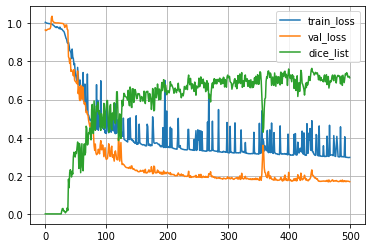

In [24]:
# Plot training loss and validation loss
plt.grid('on')
plt.plot(np.arange(NUM_EPOCH),train_loss_list,label='train_loss')
plt.plot(np.arange(NUM_EPOCH),val_loss_list, label='val_loss')
plt.plot(np.arange(NUM_EPOCH),dice_list, label='dice_list')
plt.legend()

# 6.Test

## Reload the model

In [125]:
SAVE_PATH = '/scratch/yl7692/self-attention_Unet_AND/'
checkpoint_path = SAVE_PATH +'MRISegEpoch100.pth'

net = AttU_Net(4,1).to(device)
net.load_state_dict(torch.load(checkpoint_path))
net.eval()

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, m

## Reload the data with mask1 and mask2

In [126]:
test_dataset_mask1 = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'mask1', IF_TRAIN= False)
test_dataset_mask2 = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'mask2', IF_TRAIN= False)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-8-cc23401311c6>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-8-cc23401311c6>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-8-cc23401311c6>:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predi

In [127]:
test_loader_mask1 = torch.utils.data.DataLoader(test_dataset_mask1, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader_mask2 = torch.utils.data.DataLoader(test_dataset_mask2, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

## Test with mask1 and mask2

In [128]:
def eval_epoch_with_threshold(net, data_loader, metric, criterion, threshold):
    # set model in eval mode to avoid updating BN layer
    net = net.eval()
    
    metric_stat = []
    val_loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask
        # send data to device
        img = img.to(device)
        mask = mask.to(device)
        # feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss = criterion(pred, mask)
            
        # eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred>threshold
        err = dice_coeff(pred, mask)
        metric_stat += [err.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Val Loss: {:.3f} Threshod:{:.3f}".format(np.mean(metric_stat), np.mean(val_loss_stat), threshold))
    
    return np.mean(val_loss_stat), np.mean(metric_stat)

In [129]:
test_loss, test_dice = eval_epoch(net, test_loader_mask1, dice_coeff, criterion)
test_loss, test_dice = eval_epoch(net, test_loader_mask2, dice_coeff, criterion)

Dice: 0.221  Val Loss: 0.666 
Dice: 0.292  Val Loss: 0.653 


In [130]:
for threshold in range(20):
    test_loss, test_dice = eval_epoch_with_threshold(net, test_loader_mask1, dice_coeff, criterion, threshold*0.05)
    test_loss, test_dice = eval_epoch_with_threshold(net, test_loader_mask2, dice_coeff, criterion, threshold*0.05)

Dice: 0.001  Val Loss: 0.666 Threshod:0.000
Dice: 0.002  Val Loss: 0.653 Threshod:0.000
Dice: 0.105  Val Loss: 0.666 Threshod:0.050
Dice: 0.163  Val Loss: 0.653 Threshod:0.050
Dice: 0.156  Val Loss: 0.666 Threshod:0.100
Dice: 0.227  Val Loss: 0.653 Threshod:0.100
Dice: 0.191  Val Loss: 0.666 Threshod:0.150
Dice: 0.264  Val Loss: 0.653 Threshod:0.150
Dice: 0.221  Val Loss: 0.666 Threshod:0.200
Dice: 0.292  Val Loss: 0.653 Threshod:0.200
Dice: 0.244  Val Loss: 0.666 Threshod:0.250
Dice: 0.310  Val Loss: 0.653 Threshod:0.250
Dice: 0.266  Val Loss: 0.666 Threshod:0.300
Dice: 0.323  Val Loss: 0.653 Threshod:0.300
Dice: 0.288  Val Loss: 0.666 Threshod:0.350
Dice: 0.336  Val Loss: 0.653 Threshod:0.350
Dice: 0.307  Val Loss: 0.666 Threshod:0.400
Dice: 0.342  Val Loss: 0.653 Threshod:0.400
Dice: 0.323  Val Loss: 0.666 Threshod:0.450
Dice: 0.345  Val Loss: 0.653 Threshod:0.450
Dice: 0.338  Val Loss: 0.666 Threshod:0.500
Dice: 0.345  Val Loss: 0.653 Threshod:0.500
Dice: 0.351  Val Loss: 0.666 Thr

## Dispaly the output mask

In [131]:
img, mask1 = test_dataset_mask1[0]
img, mask2 = test_dataset_mask2[0]
result = net(img.unsqueeze(0).to(device)).detach()
mask_pred = result.cpu().numpy()[0,0,:,:,:]
mask_pred[mask_pred>0.2] = 1
mask_pred[mask_pred<=0.2] = 0
print(mask_pred.shape)

(181, 217, 181)


Manual Volume for mask1: 2196.0
Manual Volume for mask2: 3123.0
Segmentation Volume: 1150216.0


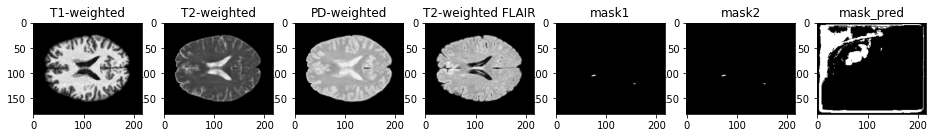

In [132]:
plt.figure(figsize = (16,32))
plt.subplot(1,7,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T1-weighted')
plt.subplot(1,7,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted')
plt.subplot(1,7,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('PD-weighted')
plt.subplot(1,7,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted FLAIR')
plt.subplot(1,7,5)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask1')
plt.subplot(1,7,6)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask2')
plt.subplot(1,7,7)
plt.imshow(mask_pred[:,:,90],'gray')
plt.title('mask_pred')

print('Manual Volume for mask1:',mask1.cpu().numpy().sum())
print('Manual Volume for mask2:',mask2.cpu().numpy().sum())
print('Segmentation Volume:',mask_pred.sum())

In [133]:
img, mask1 = test_dataset_mask1[1]
img, mask2 = test_dataset_mask2[1]
result = net(img.unsqueeze(0).to(device)).detach()
mask_pred = result.cpu().numpy()[0,0,:,:,:]
mask_pred[mask_pred>0.2] = 1
mask_pred[mask_pred<=0.2] = 0
print(mask_pred.shape)

(181, 217, 181)


Manual Volume for mask1: 5990.0
Manual Volume for mask2: 10545.0
Segmentation Volume: 19427.0


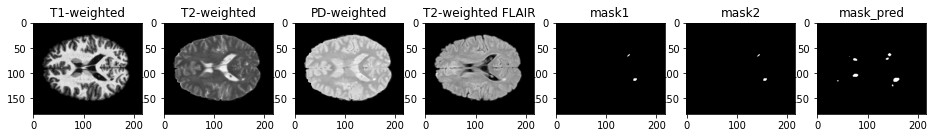

In [134]:
plt.figure(figsize = (16,32))
plt.subplot(1,7,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T1-weighted')
plt.subplot(1,7,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted')
plt.subplot(1,7,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('PD-weighted')
plt.subplot(1,7,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted FLAIR')
plt.subplot(1,7,5)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask1')
plt.subplot(1,7,6)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask2')
plt.subplot(1,7,7)
plt.imshow(mask_pred[:,:,90],'gray')
plt.title('mask_pred')

print('Manual Volume for mask1:',mask1.cpu().numpy().sum())
print('Manual Volume for mask2:',mask2.cpu().numpy().sum())
print('Segmentation Volume:',mask_pred.sum())

# Save for evaluation

In [ ]:
!wget https://smart-stats-tools.org/sites/default/files/lesion_challenge/testdata_website_2016-03-24.zip /scratch/yl7692

## Comparing with original and preprocessed

In [102]:
test_datapath = '/scratch/yl7692/testing/testdata_website'

In [103]:
orig = nib.load(test_datapath + '/test01/orig/test01_01_flair.nii.gz').get_data()
preprocessed = nib.load(test_datapath + '/test01/preprocessed/test01_01_flair_pp.nii').get_data()


<ipython-input-103-ebbfdee25ee9>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  orig = nib.load(test_datapath + '/test01/orig/test01_01_flair.nii.gz').get_data()
<ipython-input-103-ebbfdee25ee9>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  preprocessed = nib.load(test_datapath + '/test01/preprocessed/test01_01_flair_pp.nii').get_data()


In [104]:
class MRITestDataset(Dataset):
    def __init__(self, img_path_list, IF_TRAIN= False):
        self.mri_path_list = img_path_list
        self.IF_TRAIN = IF_TRAIN
        #self.transform=transforms.Compose([transforms.Normalize((0.5,),(0.5,))])
        self.mri_list = self.preprocess() 

    def __len__(self):
        return len(self.mri_list)

    def preprocess(self):
        mri_list = []
        for idx in tqdm(range(len(self.mri_path_list))):
            mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
            mri_t2f = (mri_t2f-mri_t2f.min())/(mri_t2f.max()-mri_t2f.min())
            
            mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
            mri_t1w = (mri_t1w-mri_t1w.min())/(mri_t1w.max()-mri_t1w.min())
            
            mri_pd = torch.Tensor(nib.load(self.mri_path_list[idx][2]).get_data())
            mri_pd = (mri_pd-mri_pd.min())/(mri_pd.max()-mri_pd.min())
            
            mri_t2w = torch.Tensor(nib.load(self.mri_path_list[idx][3]).get_data())
            mri_t2w = (mri_t2w-mri_t2w.min())/(mri_t2w.max()-mri_t2w.min())
            
            mri = torch.cat((mri_t1w.unsqueeze(0),mri_t2w.unsqueeze(0),mri_pd.unsqueeze(0),mri_t2f.unsqueeze(0)),axis=0)
        
            
            mri_list.append(mri)

        return mri_list

    def __getitem__ (self,idx):
        img = self.mri_list[idx]
        return img

In [105]:
second_testing_path_list = []
for i in range(1,15):
    if i<10:
        second_testing_path_list.append('test0' + str(i) + '/')
    else:
        second_testing_path_list.append('test' + str(i) + '/')
        
print(second_testing_path_list)
mri_test_list = []

for i in range(14):
    timepoint1_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_01_*.nii')
    timepoint2_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_02_*.nii')
    timepoint3_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_03_*.nii')
    timepoint4_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_04_*.nii')
    if (i==1 or i==9 or i==10 or i==13):
        timepoint5_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_05_*.nii')
    if i==9: 
        timepoint6_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_06_*.nii') 
        print(timepoint6_path)
    
    timepoint1_list = sorted(glob.glob(timepoint1_path))
    timepoint2_list = sorted(glob.glob(timepoint2_path))
    timepoint3_list = sorted(glob.glob(timepoint3_path))
    timepoint4_list = sorted(glob.glob(timepoint4_path))

    
    if (i==1 or i==9 or i==10 or i==13):
        timepoint5_list = sorted(glob.glob(timepoint5_path))
    if i==9:
        timepoint6_list = sorted(glob.glob(timepoint6_path))
    
    mri_test_list.append(timepoint1_list)
    mri_test_list.append(timepoint2_list)
    mri_test_list.append(timepoint3_list)
    mri_test_list.append(timepoint4_list)

    if (i==1 or i==9 or i==10 or i==13):
        mri_test_list.append(timepoint5_list)

    if i==9:
        mri_test_list.append(timepoint6_list)
        

print('Data Collected:', len(mri_test_list))


['test01/', 'test02/', 'test03/', 'test04/', 'test05/', 'test06/', 'test07/', 'test08/', 'test09/', 'test10/', 'test11/', 'test12/', 'test13/', 'test14/']
/scratch/yl7692/testing/testdata_website/test10/preprocessed/*_06_*.nii
Data Collected: 61


In [106]:
test_dataset = MRITestDataset(mri_test_list, IF_TRAIN= True)

  0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-104-cca191b18e00>:14: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-104-cca191b18e00>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-104-cca191b18e00>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mor

In [107]:
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=1, 
                                         shuffle=False, 
                                         num_workers=0)

In [108]:
def pre_and_save(net, dataloader):
    net = net.eval()
    num_list = [4,5,4,4,4,4,4,4,4,6,5,4,4,5]
    cnt_num = 0;
    cnt = 0;
    for i, test_input in enumerate(dataloader):
        test_input = test_input.to(device)
        with torch.no_grad():
            pred = net(test_input[0].unsqueeze(0).to(device)).detach()
            pred[pred>0.2] = 1
            pred[pred<=0.2] = 0
            pred = pred.cpu().numpy().squeeze()
            new_image = nib.Nifti1Image(pred, np.eye(4)) 
            
        if (cnt == num_list[cnt_num]):
            cnt_num += 1
            cnt = 0;
        if i < 37:
            nib.save(new_image, '/scratch/yl7692/self-attention_Unet_AND_test_result/' + 'test0' + str(cnt_num+1) + '_0' + str(cnt+1)+ '_NYU.nii')
        else:
            nib.save(new_image, '/scratch/yl7692/self-attention_Unet_AND_test_result/' + 'test' + str(cnt_num+1) + '_0' + str(cnt+1)+ '_NYU.nii')
        cnt = cnt+1

In [109]:
num_list = [4,5,4,4,4,4,4,4,4,6,5,4,4,5]
print(sum(num_list))

61


In [110]:
pre_and_save(net, test_loader)

(181, 217, 181)


<ipython-input-112-ed71696282e4>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  testimg = nib.load('/scratch/yl7692/self-attention_Unet_AND_test_result/test12_02_NYU.nii').get_data()


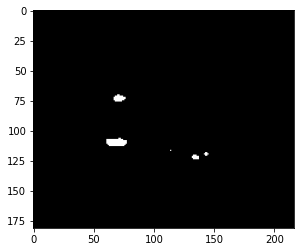

In [112]:
testimg = nib.load('/scratch/yl7692/self-attention_Unet_AND_test_result/test12_02_NYU.nii').get_data()
print(testimg.shape)
plt.imshow(testimg[:,:,90], cmap='gray')